# Description

### Zindi User Behaviour Modelling: Due to relative amount of information available at test time for different users- we create groupings for prediction on test set- Month 1, Month 2, Month 3 and new users with no historical information. 
### At each step, we train and optimize different models and match the train setup and feature selection to expected test time conditions. 

In [200]:
import gc
gc.collect()

98

In [201]:
import os
os.getcwd()

'/Users/damolaoriola/Documents/Zindi/USER BEHAVIOUR/TEAM FLAME'

In [202]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from tqdm import tqdm
import seaborn as sns
sns.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.patches as mpatches
from pandas.tseries.offsets import DateOffset
from dateutil import relativedelta
import re
import random
rand = 40
np.random.seed(rand)
random.seed(rand)
tqdm.pandas()
import logging
logging.basicConfig(level='INFO')
import os

In [203]:
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold  , StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [204]:
#import generated dataset from Python

all_data= pd.read_pickle('./data/Final Data Prep.pkl', compression = 'gzip')

**Load additional features from R and include in dataframe for model training**

In [206]:
holar = pd.read_csv('./data/Best_Data.csv')

In [207]:
holar.head()

,Year,UserID,Month,part_date_count,FeatureX,Country,FeatureY,Points,no_of_comp,total_subm_count,total_disc,total_comments,tenor,tenor3,date_cnt,partdate_country_cnt,country_joindate_cnt,country_tenor_cnt
0,2020,ID_XI7BAR4Y,8,16934,0,70,0,3,2,5,999,999,759,547,295,1339,1378,171
1,2019,ID_XI7BAR4Y,8,5380,0,70,0,3,2,5,999,999,759,181,295,343,1378,141
2,2019,ID_XI7BAR4Y,9,6523,0,70,0,3,2,5,999,999,759,212,295,418,1378,154
3,2020,ID_XI7BAR4Y,9,17457,0,70,0,3,2,5,999,999,759,578,295,1384,1378,158
4,2020,ID_XI7BAR4Y,10,18697,0,70,0,3,2,5,999,999,759,608,295,1480,1378,76


In [208]:
year_dict = {2018 : 1, 2019 : 2, 2020 : 3,  2021 : 4}

holar['Year'] = holar['Year'].map(year_dict)

In [209]:
holar = holar.drop(['FeatureX', 'Country', 'FeatureY', 'Points'], axis = 1)

In [210]:
holar = holar.rename(columns = {'Year' : 'year', 'Month' : 'month'})

In [211]:
all_data = all_data.merge(holar, on =['UserID', 'month', 'year'], how = 'left')

## EDA-

### DATA OVERVIEW

In [212]:
all_data.head()

,UserID,month,year,CompPart,Comment,Sub,Disc,Target,tag,FeatureX,...,no_of_comp,total_subm_count,total_disc,total_comments,tenor,tenor3,date_cnt,partdate_country_cnt,country_joindate_cnt,country_tenor_cnt
0,ID_XI7BAR4Y,8,3,0.0,0.0,0.0,0.0,0.0,train,0,...,2,5,999,999,759,547,295,1339,1378,171
1,ID_XI7BAR4Y,8,2,0.0,0.0,0.0,0.0,0.0,train,0,...,2,5,999,999,759,181,295,343,1378,141
2,ID_XI7BAR4Y,9,2,0.0,0.0,0.0,0.0,0.0,train,0,...,2,5,999,999,759,212,295,418,1378,154
3,ID_XI7BAR4Y,9,3,0.0,0.0,0.0,0.0,0.0,train,0,...,2,5,999,999,759,578,295,1384,1378,158
4,ID_XI7BAR4Y,10,3,0.0,0.0,0.0,0.0,0.0,train,0,...,2,5,999,999,759,608,295,1480,1378,76


In [214]:
all_data.isnull().sum().tail(100)

SumSubCountPrev6Mon          0
minPointsPrev6Mon       199051
maxPointsPrev6Mon       199051
meanPointsPrev6Mon      199051
medPointsPrev6Mon       199051
                         ...  
tenor3                       0
date_cnt                     0
partdate_country_cnt         0
country_joindate_cnt         0
country_tenor_cnt            0
Length: 100, dtype: int64

In [215]:
import gc
gc.collect()

29

In [216]:
all_data = all_data.drop(['timestamp'], axis = 1)

In [217]:
#Extract columns

def Column_types():

    skip_cols = ['tag']
    cols = [col for col in all_data.columns]
    cat_cols = [col for col in cols if all_data[col].dtype == 'O' and 'Date' not in col]
    date_cols = [col for col in cols if 'Date' in col]
    num_cols = list(set(cols)-set(cat_cols + date_cols))
    
    return cat_cols, date_cols, num_cols

In [218]:
cat_cols, date_cols, num_cols = Column_types()

## Exploratory Data Analysis on the datatypes

### NUMERIC

#### UNIVARIATE & BIVARIATE

In [219]:
all_data.head()

,UserID,month,year,CompPart,Comment,Sub,Disc,Target,tag,FeatureX,...,no_of_comp,total_subm_count,total_disc,total_comments,tenor,tenor3,date_cnt,partdate_country_cnt,country_joindate_cnt,country_tenor_cnt
0,ID_XI7BAR4Y,8,3,0.0,0.0,0.0,0.0,0.0,train,0,...,2,5,999,999,759,547,295,1339,1378,171
1,ID_XI7BAR4Y,8,2,0.0,0.0,0.0,0.0,0.0,train,0,...,2,5,999,999,759,181,295,343,1378,141
2,ID_XI7BAR4Y,9,2,0.0,0.0,0.0,0.0,0.0,train,0,...,2,5,999,999,759,212,295,418,1378,154
3,ID_XI7BAR4Y,9,3,0.0,0.0,0.0,0.0,0.0,train,0,...,2,5,999,999,759,578,295,1384,1378,158
4,ID_XI7BAR4Y,10,3,0.0,0.0,0.0,0.0,0.0,train,0,...,2,5,999,999,759,608,295,1480,1378,76


In [220]:
all_data.columns

Index(['UserID', 'month', 'year', 'CompPart', 'Comment', 'Sub', 'Disc',
       'Target', 'tag', 'FeatureX',
       ...
       'no_of_comp', 'total_subm_count', 'total_disc', 'total_comments',
       'tenor', 'tenor3', 'date_cnt', 'partdate_country_cnt',
       'country_joindate_cnt', 'country_tenor_cnt'],
      dtype='object', length=361)

<AxesSubplot:xlabel='Target', ylabel='count'>

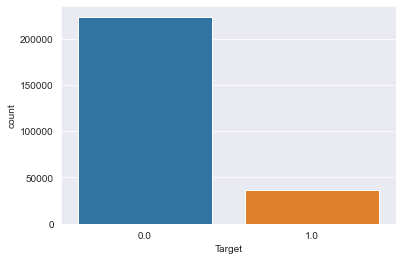

In [221]:
#Check target distribution

sns.countplot(data = all_data, x = 'Target')

In [222]:
all_data['Target'].value_counts()/len(all_data[all_data['tag'] == 'train'])

0.0    0.860271
1.0    0.139729
Name: Target, dtype: float64

In [223]:
all_data['Target'].value_counts()

0.0    223526
1.0     36306
Name: Target, dtype: int64

In [224]:
223571/36376

6.146112821640642

Imbalanced classification of 86% no active and 14% user activity

In [225]:
num_cols

['MedianCompPart6Mon',
 'num_days_last_active',
 'MaxDiscPrev6Mon',
 'meanPointsPrev6Mon',
 'maxDurationPrev6Mon',
 'lag_2',
 'MinCompPartall',
 'MaxDiscPrevMon',
 'MaxCompPart3Mon',
 'maxCompPoints',
 'lag_3_TargetSum',
 'noCompPartPrev3MonActive',
 'maxRankPrevMon',
 'minsubCount',
 'MeanSubFeatGPrevMon',
 'noCompPartPrevMonnosec',
 'minRankPrev6Mon',
 'HistSub',
 'MeanSubFeatGPrev6Mon',
 'noCompnosec',
 'MedianSuball',
 'medDurationPrevMon',
 'meanDurationPrev3Mon',
 'Hist3CompPart',
 'sumCompFeatC',
 'user_min_active',
 'maxPointsPrev6MonActive',
 'sumSubCountPrev3MonActive',
 'minCompPoints',
 'maxDurationPrev3Mon',
 'noCommPrevMon',
 'medRankPrev3Mon',
 'lag_4_TargetSum',
 'MaxCompPartall',
 'total_sub_compratio',
 '3monconsistencyIndex',
 'noSubStatsPrev3Mon',
 'sumPoints',
 'meanRankPrev3Mon',
 'SumDiscFeatFPrev6Mon',
 'HistDiscPrev2Mon',
 'MeanCompPart3Mon',
 'maxCompDuration',
 'medPointsPrev6Mon',
 'meansubCountPrev3MonActive',
 'MinCompPart6Mon',
 'SumSubFeatGPrev3Mon',
 'H

In [226]:
all_data[num_cols].describe()

,MedianCompPart6Mon,num_days_last_active,MaxDiscPrev6Mon,meanPointsPrev6Mon,maxDurationPrev6Mon,lag_2,MinCompPartall,MaxDiscPrevMon,MaxCompPart3Mon,maxCompPoints,...,MinCompPart3Mon,HistSubPrev3Mon,maxRankPrevMonActive,SumKindPrev6Mon,HistDiscPrev3Mon,minDurationPrev3Mon,noDiscPrevMon,meanPointsPrev6MonActive,months_3,user_median_active
count,126004.000000,320486.000000,17452.000000,126004.000000,112730.000000,259832.000000,222945.000000,3776.000000,77011.000000,325055.000000,...,77011.000000,259832.000000,6652.000000,325055.000000,259832.000000,68676.000000,325055.000000,36778.000000,325055.000000,300268.000000
mean,1.412269,7.103193,1.598441,148.290393,4.014841,0.139729,1.227608,1.581568,1.586825,512.327142,...,1.371687,0.064676,6.815695,0.653563,0.014532,3.153707,0.018372,228.140539,2.573075,1.105003
std,0.918668,7.877081,2.125508,145.454915,2.026206,0.346706,0.709299,2.034593,1.242551,24.269893,...,0.936449,0.245954,3.920041,1.488992,0.119672,1.775871,0.277118,151.557241,0.914009,0.832293
min,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,500.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,3.000000,0.000000,1.000000,1.000000,1.000000,500.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,102.000000,3.000000,1.000000
50%,1.000000,5.000000,1.000000,122.436508,4.000000,0.000000,1.000000,1.000000,1.000000,500.000000,...,1.000000,0.000000,8.000000,0.000000,0.000000,3.000000,0.000000,211.000000,3.000000,1.000000
75%,1.500000,10.000000,2.000000,251.000000,5.000000,0.000000,1.000000,2.000000,2.000000,500.000000,...,1.000000,0.000000,11.000000,1.000000,0.000000,4.000000,0.000000,301.000000,3.000000,1.000000
max,28.000000,65.000000,52.000000,599.000000,12.000000,1.000000,28.000000,52.000000,28.000000,599.000000,...,28.000000,1.000000,11.000000,35.000000,1.000000,12.000000,52.000000,599.000000,3.000000,31.000000


Observation- General user activity is low on the platform, with most users not very active across months. We learn patterns that distinguish active users from inactive ones.

In [227]:
all_data.columns

Index(['UserID', 'month', 'year', 'CompPart', 'Comment', 'Sub', 'Disc',
       'Target', 'tag', 'FeatureX',
       ...
       'no_of_comp', 'total_subm_count', 'total_disc', 'total_comments',
       'tenor', 'tenor3', 'date_cnt', 'partdate_country_cnt',
       'country_joindate_cnt', 'country_tenor_cnt'],
      dtype='object', length=361)

In [228]:
all_data.columns[200:]

Index(['MinDiscPrevMon', 'MeanDiscPrevMon', 'MedianDiscPrevMon',
       'MaxDiscPrevMon', 'TotalnoCompPrevMon', 'PrevMon_disc_compratio',
       'PrevMon_sub_compratio', 'PrevMon_comm_compratio',
       'PrevMoncompInteractionratio', 'noCompPartPrev3Mon',
       ...
       'no_of_comp', 'total_subm_count', 'total_disc', 'total_comments',
       'tenor', 'tenor3', 'date_cnt', 'partdate_country_cnt',
       'country_joindate_cnt', 'country_tenor_cnt'],
      dtype='object', length=161)

In [229]:
#drop target component features
all_data = all_data.drop(['CompPart', 'Comment', 'Sub', 'Disc', 'TargetSum'], axis = 1)

In [230]:
#drop extra ratio features

all_data = all_data.drop(['Hist3TotActRatio', 'Hist6TotActRatio'], axis = 1)

In [232]:
all_data.columns

Index(['UserID', 'month', 'year', 'Target', 'tag', 'FeatureX', 'Country',
       'FeatureY', 'Points', 'UserDate Year',
       ...
       'no_of_comp', 'total_subm_count', 'total_disc', 'total_comments',
       'tenor', 'tenor3', 'date_cnt', 'partdate_country_cnt',
       'country_joindate_cnt', 'country_tenor_cnt'],
      dtype='object', length=354)

**Visualizing User historical Activity Features:**

**HistComm**

<AxesSubplot:xlabel='HistComm'>

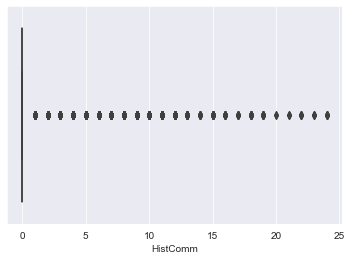

In [233]:
sns.boxplot(all_data['HistComm'])

<AxesSubplot:xlabel='Target', ylabel='HistComm'>

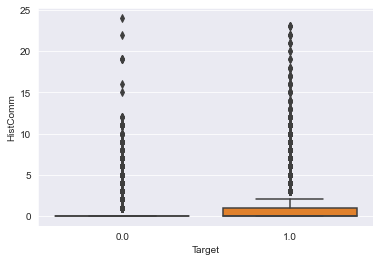

In [234]:
sns.boxplot(x = 'Target', y = 'HistComm',  data = all_data)

**HistSub**

<AxesSubplot:xlabel='HistSub'>

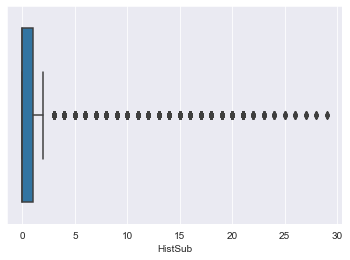

In [235]:
sns.boxplot(all_data['HistSub'])

<AxesSubplot:xlabel='Target', ylabel='HistSub'>

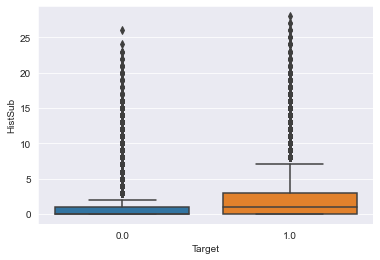

In [236]:
sns.boxplot(x = 'Target', y = 'HistSub',  data = all_data)

**HistDisc**

<AxesSubplot:xlabel='HistDisc'>

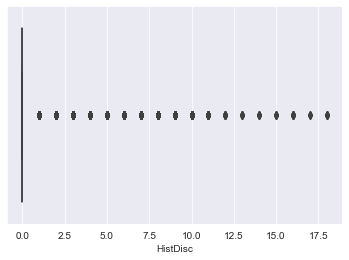

In [237]:
sns.boxplot(all_data['HistDisc'])

<AxesSubplot:xlabel='Target', ylabel='HistDisc'>

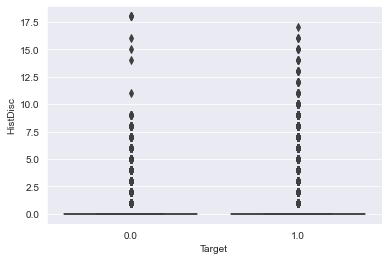

In [238]:
sns.boxplot(x = 'Target', y = 'HistDisc',  data = all_data)

**HistCompPart**

<AxesSubplot:xlabel='HistCompPart'>

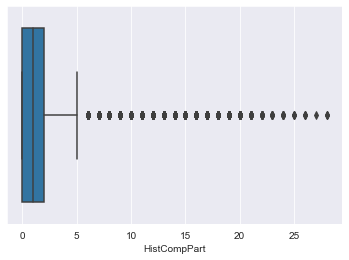

In [239]:
sns.boxplot(all_data['HistCompPart'])

<AxesSubplot:xlabel='Target', ylabel='HistCompPart'>

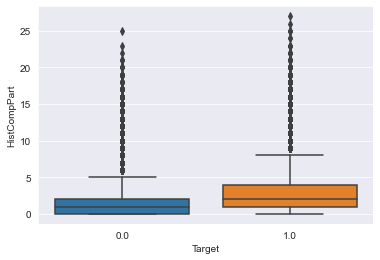

In [240]:
sns.boxplot(x = 'Target', y = 'HistCompPart',  data = all_data)

**HistTotAct**

<AxesSubplot:xlabel='HistTotAct'>

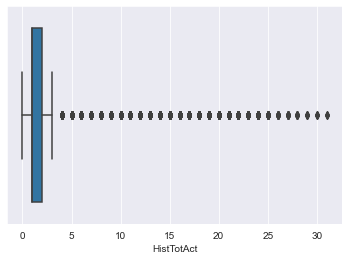

In [241]:
sns.boxplot(all_data['HistTotAct'])

<AxesSubplot:xlabel='Target', ylabel='HistTotAct'>

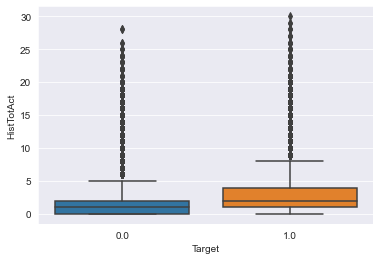

In [242]:
sns.boxplot(x = 'Target', y = 'HistTotAct',  data = all_data)

**Overalluserbev**

<AxesSubplot:xlabel='Target', ylabel='Overalluserbev'>

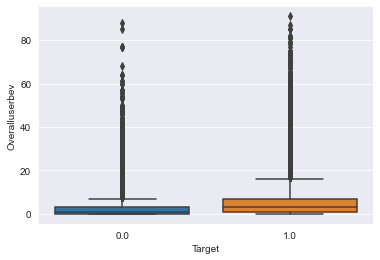

In [243]:
sns.boxplot(x = 'Target', y = 'Overalluserbev',  data = all_data)

In [244]:
all_data.head()

,UserID,month,year,Target,tag,FeatureX,Country,FeatureY,Points,UserDate Year,...,no_of_comp,total_subm_count,total_disc,total_comments,tenor,tenor3,date_cnt,partdate_country_cnt,country_joindate_cnt,country_tenor_cnt
0,ID_XI7BAR4Y,8,3,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,547,295,1339,1378,171
1,ID_XI7BAR4Y,8,2,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,181,295,343,1378,141
2,ID_XI7BAR4Y,9,2,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,212,295,418,1378,154
3,ID_XI7BAR4Y,9,3,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,578,295,1384,1378,158
4,ID_XI7BAR4Y,10,3,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,608,295,1480,1378,76


In [245]:
all_data.columns

Index(['UserID', 'month', 'year', 'Target', 'tag', 'FeatureX', 'Country',
       'FeatureY', 'Points', 'UserDate Year',
       ...
       'no_of_comp', 'total_subm_count', 'total_disc', 'total_comments',
       'tenor', 'tenor3', 'date_cnt', 'partdate_country_cnt',
       'country_joindate_cnt', 'country_tenor_cnt'],
      dtype='object', length=354)

In [246]:
num_cols

['MedianCompPart6Mon',
 'num_days_last_active',
 'MaxDiscPrev6Mon',
 'meanPointsPrev6Mon',
 'maxDurationPrev6Mon',
 'lag_2',
 'MinCompPartall',
 'MaxDiscPrevMon',
 'MaxCompPart3Mon',
 'maxCompPoints',
 'lag_3_TargetSum',
 'noCompPartPrev3MonActive',
 'maxRankPrevMon',
 'minsubCount',
 'MeanSubFeatGPrevMon',
 'noCompPartPrevMonnosec',
 'minRankPrev6Mon',
 'HistSub',
 'MeanSubFeatGPrev6Mon',
 'noCompnosec',
 'MedianSuball',
 'medDurationPrevMon',
 'meanDurationPrev3Mon',
 'Hist3CompPart',
 'sumCompFeatC',
 'user_min_active',
 'maxPointsPrev6MonActive',
 'sumSubCountPrev3MonActive',
 'minCompPoints',
 'maxDurationPrev3Mon',
 'noCommPrevMon',
 'medRankPrev3Mon',
 'lag_4_TargetSum',
 'MaxCompPartall',
 'total_sub_compratio',
 '3monconsistencyIndex',
 'noSubStatsPrev3Mon',
 'sumPoints',
 'meanRankPrev3Mon',
 'SumDiscFeatFPrev6Mon',
 'HistDiscPrev2Mon',
 'MeanCompPart3Mon',
 'maxCompDuration',
 'medPointsPrev6Mon',
 'meansubCountPrev3MonActive',
 'MinCompPart6Mon',
 'SumSubFeatGPrev3Mon',
 'H

In [247]:
all_data.head()

,UserID,month,year,Target,tag,FeatureX,Country,FeatureY,Points,UserDate Year,...,no_of_comp,total_subm_count,total_disc,total_comments,tenor,tenor3,date_cnt,partdate_country_cnt,country_joindate_cnt,country_tenor_cnt
0,ID_XI7BAR4Y,8,3,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,547,295,1339,1378,171
1,ID_XI7BAR4Y,8,2,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,181,295,343,1378,141
2,ID_XI7BAR4Y,9,2,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,212,295,418,1378,154
3,ID_XI7BAR4Y,9,3,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,578,295,1384,1378,158
4,ID_XI7BAR4Y,10,3,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,608,295,1480,1378,76


In [248]:
all_data.columns

Index(['UserID', 'month', 'year', 'Target', 'tag', 'FeatureX', 'Country',
       'FeatureY', 'Points', 'UserDate Year',
       ...
       'no_of_comp', 'total_subm_count', 'total_disc', 'total_comments',
       'tenor', 'tenor3', 'date_cnt', 'partdate_country_cnt',
       'country_joindate_cnt', 'country_tenor_cnt'],
      dtype='object', length=354)

In [249]:
all_data['Points'].value_counts()

group 1    190880
group 3    129485
group 2      3504
group 4      1186
Name: Points, dtype: int64

In [250]:
all_data.head()

,UserID,month,year,Target,tag,FeatureX,Country,FeatureY,Points,UserDate Year,...,no_of_comp,total_subm_count,total_disc,total_comments,tenor,tenor3,date_cnt,partdate_country_cnt,country_joindate_cnt,country_tenor_cnt
0,ID_XI7BAR4Y,8,3,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,547,295,1339,1378,171
1,ID_XI7BAR4Y,8,2,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,181,295,343,1378,141
2,ID_XI7BAR4Y,9,2,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,212,295,418,1378,154
3,ID_XI7BAR4Y,9,3,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,578,295,1384,1378,158
4,ID_XI7BAR4Y,10,3,0.0,train,0,ID_GU74,0,group 3,2,...,2,5,999,999,759,608,295,1480,1378,76


### CATEGORICAL

In [56]:
# for col in cat_cols:
    
#     plt.figure(figsize = (20, 5))
#     plt.xticks(rotation = 90)
#     plt.title(col + ' by Target Mean')
    
#     cat = all_data.groupby(col)['Target'].mean().sort_values()
#     sns.barplot(cat.index, cat.values, palette = 'Blues_r')
# plt.show()

In [251]:
def catplot_distribution(col):
    
    ax = all_data[col].value_counts().sort_values().plot(kind = 'barh', figsize=(15, 15))
    plt.title(col + ' Distribution', fontdict={'size': 15})
    
    for p in ax.patches:
        
        percentage ='{:,.2f}%'.format((p.get_width()/all_data.shape[0])*100)
        width, height =p.get_width(),p.get_height()
        x=p.get_x()+width+0.02
        y=p.get_y()+height/2
        ax.annotate(percentage,(x,y))
        
    
    plt.show()


In [252]:
cat_cols

['UserID',
 'tag',
 'Country',
 'Points',
 'modeCompFeatA',
 'modeCompFeatB',
 'modeCompFeatE',
 'modeCompCountry']

***Analysis- Explore Country***

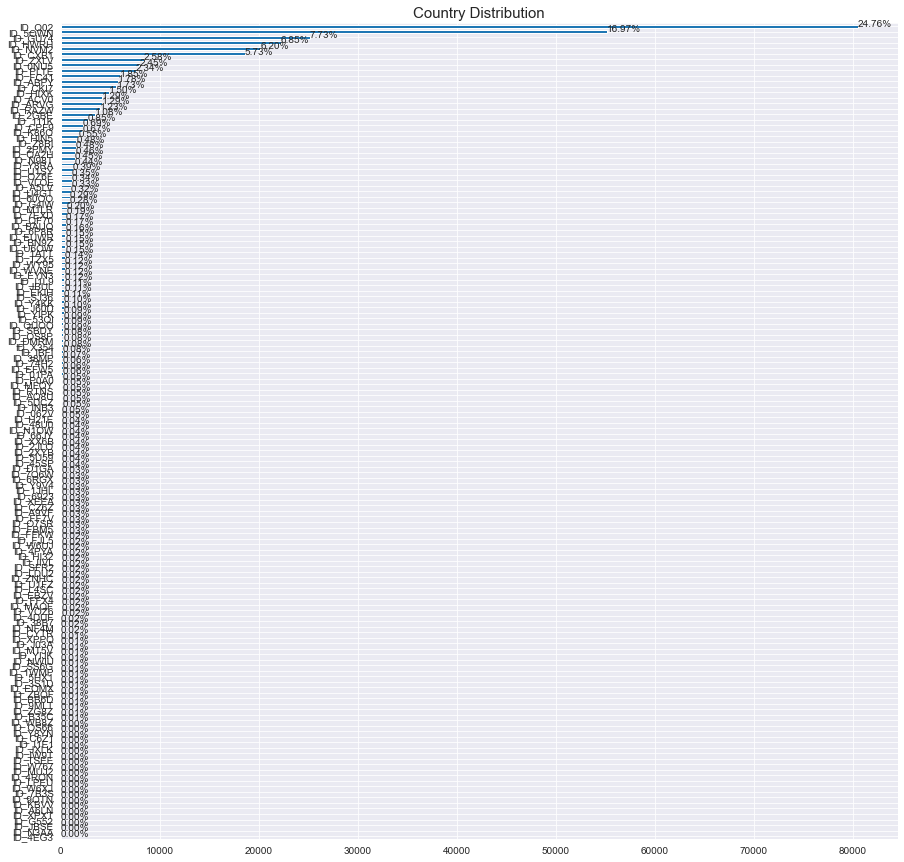

In [253]:
# Education Level distribution 
catplot_distribution('Country')

## MODEL BUILDING: There are different kinds of users, hence we utilize 3 different approaches depending on the user type case

In [254]:
cat_cols, date_cols, num_cols = Column_types()

In [255]:
all_data.dtypes[:15]

UserID                   object
month                     int64
year                      int64
Target                  float64
tag                      object
FeatureX                  int64
Country                  object
FeatureY                  int64
Points                   object
UserDate Year             int64
UserDate Month            int64
UserDate Day_of_week      int64
noComp                    int64
noCompsec                 int64
noCompnosec               int64
dtype: object

In [256]:
all_data['month'] = all_data['month'].astype(int)

In [257]:
all_data['month'].value_counts()

3     38480
2     36136
1     33732
12    31666
11    29523
10    27659
9     24920
8     23153
7     21991
6     20504
5     19405
4     17886
Name: month, dtype: int64

In [258]:
cat_cols

['UserID',
 'tag',
 'Country',
 'Points',
 'modeCompFeatA',
 'modeCompFeatB',
 'modeCompFeatE',
 'modeCompCountry']

In [259]:
all_data.isnull().sum()

UserID                      0
month                       0
year                        0
Target                  65223
tag                         0
                        ...  
tenor3                      0
date_cnt                    0
partdate_country_cnt        0
country_joindate_cnt        0
country_tenor_cnt           0
Length: 354, dtype: int64

In [260]:
#Extract categorical

cat_cols = []

for col in all_data.columns:
    
    if all_data[col].dtype == 'O':
        
        cat_cols.append(col)

In [261]:
cat_cols

['UserID',
 'tag',
 'Country',
 'Points',
 'modeCompFeatA',
 'modeCompFeatB',
 'modeCompFeatE',
 'modeCompCountry']

In [262]:
cat_cols.remove('tag')
cat_cols.remove('UserID')


In [263]:
all_data.columns

Index(['UserID', 'month', 'year', 'Target', 'tag', 'FeatureX', 'Country',
       'FeatureY', 'Points', 'UserDate Year',
       ...
       'no_of_comp', 'total_subm_count', 'total_disc', 'total_comments',
       'tenor', 'tenor3', 'date_cnt', 'partdate_country_cnt',
       'country_joindate_cnt', 'country_tenor_cnt'],
      dtype='object', length=354)

In [264]:
for col in cat_cols:

    all_data[col] = pd.factorize(all_data[col])[0]

In [265]:
train = all_data[all_data['tag'] == 'train']

test = all_data[all_data['tag'] == 'test']


train = train.drop(['tag'], axis = 1)

test_new = test.drop(['tag'], axis = 1)

In [266]:
train.shape, test_new.shape

((259832, 353), (65223, 353))

In [267]:
train.columns

Index(['UserID', 'month', 'year', 'Target', 'FeatureX', 'Country', 'FeatureY',
       'Points', 'UserDate Year', 'UserDate Month',
       ...
       'no_of_comp', 'total_subm_count', 'total_disc', 'total_comments',
       'tenor', 'tenor3', 'date_cnt', 'partdate_country_cnt',
       'country_joindate_cnt', 'country_tenor_cnt'],
      dtype='object', length=353)

In [268]:
cat_cols

['Country',
 'Points',
 'modeCompFeatA',
 'modeCompFeatB',
 'modeCompFeatE',
 'modeCompCountry']

### Building separate approaches for test set: Users with different amount of lag/historical information to rely on from previous months & Users without any lag/historical information to rely on

In [269]:
train_test_users = list(set(test['UserID']).intersection(set(train['UserID'])))

In [270]:
train_test_users

['ID_CA6IBIY1',
 'ID_Z3DL2YCA',
 'ID_QZ3KCRS6',
 'ID_EPXVILP5',
 'ID_IJT400XV',
 'ID_HDFEWTOG',
 'ID_8A9PVKUK',
 'ID_M6T65OZ3',
 'ID_U5X8WN7I',
 'ID_6GW7HXOS',
 'ID_I6TVP8M0',
 'ID_EE1DSOVA',
 'ID_BOC8SW8J',
 'ID_709TIFW1',
 'ID_DELZFQYQ',
 'ID_V6U1SHGP',
 'ID_86HB7Z03',
 'ID_4IOQSSER',
 'ID_GWMSBIOL',
 'ID_B7XM9X8U',
 'ID_8Y5SYC25',
 'ID_I4YU8WMH',
 'ID_N013WM0E',
 'ID_TDVA7J40',
 'ID_KM3WVGF3',
 'ID_1DFO4DM4',
 'ID_G6KO9RJB',
 'ID_ESGMR7NO',
 'ID_MN0C91NU',
 'ID_FLSZ84LF',
 'ID_TMLPT3ES',
 'ID_M8Z5T722',
 'ID_E5RUVM21',
 'ID_YSOFESY1',
 'ID_0N50D9I2',
 'ID_CBG0IP9F',
 'ID_SSYA0A46',
 'ID_SDBZ2E3P',
 'ID_G32RF119',
 'ID_POEKJRIX',
 'ID_A7S1TRHQ',
 'ID_2TSYQIDH',
 'ID_TGCCHSWE',
 'ID_E3MBNUZO',
 'ID_3Z9BNM1S',
 'ID_5XHZWA0W',
 'ID_0Q58U8GO',
 'ID_XFSANDTM',
 'ID_UAHFLWY5',
 'ID_XT54M2NX',
 'ID_DE47BC9C',
 'ID_RBSOPQ40',
 'ID_N3WW5GFH',
 'ID_94CX8GS5',
 'ID_7X4GG7OY',
 'ID_WKD592BL',
 'ID_7308Z32H',
 'ID_NRUFJV0M',
 'ID_TWXMFT24',
 'ID_MLWRM7H8',
 'ID_K0VJOEQK',
 'ID_V21WL7EN',
 'ID_N5C

In [271]:
nontrain_test_users = set(test['UserID'])-set(train_test_users)

In [272]:
train.shape, test_new.shape

((259832, 353), (65223, 353))

In [273]:
all_test = pd.DataFrame(columns = ['UserID', 'year', 'month', 'Target'])
all_test

,UserID,year,month,Target


In [274]:
test_new['month'].value_counts()

3    22402
2    21881
1    20940
Name: month, dtype: int64

**Case 1- Building a model for users with enough historical information from the previous month: Year 4, Month 1**

In [275]:
test_new_month1 = test_new[test_new['UserID'].isin(train_test_users) & (test_new['month'] == 1)]
test_new_others = test_new.drop(test_new_month1.index)

In [276]:
import gc
gc.collect()

24128

In [277]:
train.columns[280:]

Index(['MedianDiscPrev6Mon', 'MaxDiscPrev6Mon', 'num_days_last_active',
       'num_days_last_active_6mon', 'user_min_active', 'user_max_active',
       'user_median_active', 'user_mean_active', 'user_sum_active', 'quarter',
       'pos_pos_behav', 'neg_neg_behav', 'neg_pos_behav', 'pos_neg_behav',
       'noCompPartPrevMonActive', 'sumRankPrevMonActive',
       'minRankPrevMonActive', 'maxRankPrevMonActive', 'medRankPrevMonActive',
       'meanRankPrevMonActive', 'sumSubCountPrevMonActive',
       'medsubCountPrevMonActive', 'minsubCountPrevMonActive',
       'maxsubCountPrevMonActive', 'meansubCountPrevMonActive',
       'minPointsPrevMonActive', 'maxPointsPrevMonActive',
       'meanPointsPrevMonActive', 'medPointsPrevMonActive',
       'sumPointsPrevMonActive', 'noCompPartPrev3MonActive',
       'sumRankPrev3MonActive', 'minRankPrev3MonActive',
       'maxRankPrev3MonActive', 'medRankPrev3MonActive',
       'meanRankPrev3MonActive', 'sumSubCountPrev3MonActive',
       'medsubCountP

In [278]:
#Feature selection 

drop_month1 = ['HistCommPrev6Mon',
 'PrevMon_disc_compratio',
 'MeanDiscFeatFPrev3Mon',
 'lag_5_TargetSum',
 '6monconsistencyWeighting_0.8',
 'MinCompPart3Mon',
 'Hist6TotAct',
 'meanRankPrev6Mon',
 'lag_3',
 'HistCompPartPrev2Mon',
 'minDurationPrev6Mon',
 'SumKindPrev6Mon',
 'medDurationPrevMon',
 'noDiscPrevMon',
 'SumSubCountPrev6Mon',
 'Hist3Comm',
 'meanCompFeatD',
 'noCompsec',
 '6monconsistencyWeighting',
 'HistSubPrev6Mon',
 'user_median_active',
 'Hist6Sub',
 'meanuserstartPrevMon',
 'maxsubCountPrev3Mon',
 'meanCompPoints',
 'HistSubPrev3Mon',
 'MeanDiscFeatFall',
 'MedianDiscPrevMon',
 'modeCompCountry',
 'months_6',
 'HistDiscPrev2Mon',
 'total_sub_compratio',
 'MinDiscall',
 'HistDiscPrev4Mon',
 'MaxCompPart3Mon',
 'noDiscPrev3Mon',
 'MedianCompPart3Mon',
 'HistCompPartPrev3Mon',
 'noCompPartPrevMonnosec',
 'meanRankPrev3Mon',
 'HistSub',
 'SumDiscFeatFPrev3Mon',
 'year',
 'maxsubCount',
 'MaxCompPart6Mon',
 'modeCompFeatD',
 'user_min_active',
 'modeCompFeatE',
 'SumSubFeatGPrevMon',
 'maxuserstartPrev3Mon',
 'SumSubCount',
 'MaxDiscPrev6Mon',
 'maxRankPrev6Mon',
 'minPointsPrevMon',
 'MedianSuball',
 'user_mean_active',
 'MaxDiscPrevMon',
 'medRankPrevMon',
 'HistDiscRatio',
 'medCompPoints',
 'lag_2_TargetSum',
 'maxuserstart',
 'medsubCountPrev3Mon',
 'meanCompDuration',
 'medSublimit',
 'HistTotActRatio',
 'sumCompFeatD',
 'noCommStatsall',
 'meanRankPrevMon',
 'MinDiscPrev3Mon',
 'SumDiscFeatFPrevMon',
 'MaxCompPartall',
 'HistCompPartPrevMon',
 'HistCommPrev5Mon',
 'HistCompPartPrev6Mon',
 'MinSuball',
 'MedianDiscPrev3Mon',
 'Hist6Comm',
 'medRankPrev6Mon',
 'minuserstartPrevMon',
 'sumPointsPrev3Mon',
 'SumDiscFeatFPrev6Mon',
 'MedianCompPart6Mon',
 'noSubStatsPrevMon',
 'HistCommPrevMon',
 'lag_5',
 'meduserstartPrev3Mon',
 'sumCompKind',
 'medDurationPrev3Mon',
 'noSubStatsPrev3Mon',
 'meduserstartPrevMon',
 'Hist6CompPart',
 'MaxDiscall',
 'minPointsPrev6Mon',
 'Hist3Disc',
 'MeanDiscFeatFPrevMon',
 'MinDiscPrevMon',
 'noCompPartPrevMonsec',
 'meanDurationPrevMon',
 'meanCompKind',
 'MeanDiscPrev3Mon',
 'minCompPoints',
 'minDurationPrevMon',
 'Hist6Disc',
 'medCompFeatC',
 'noCompPartall',
 'meansubCountPrev6Mon',
 'minRankPrev3Mon',
 'MeanDiscall',
 'maxCompFeatC',
 'MeanCompPart6Mon',
 'medpublicRank',
 'UserID',
 'lag_6_TargetSum',
 'MeanSubFeatGPrev3Mon',
 'HistDisc',
 'HistDiscPrev5Mon',
 'minSublimit',
 'HistCommPrev2Mon',
 'HistCommPrev3Mon',
 'maxCompDuration',
 'maxCompPoints',
 'maxRankPrev3Mon',
 'HistDiscPrev6Mon',
 'noCompPartPrev3Mon',
 'lag_4',
 'sumPointsPrevMon',
 'Hist3TotAct',
 'maxuserstartPrevMon',
 'Hist3CompPart',
 'total_comm_compratio',
 'MinCompPartall',
 'SumDiscFeatFall',
 'noCommPrev6Mon',
 'medCompMonth',
 'MeanSubFeatGPrevMon',
 'MeanDiscPrev6Mon',
 'PrevMoncompInteractionratio',
 'maxDurationPrevMon',
 'minsubCount',
 'maxPointsPrev3Mon',
 'medDurationPrev6Mon',
 'meanuserstart',
 'noCompPartPrev3Monsec',
 'HistCompPartPrev5Mon',
 'noCompPartPrev6Monsec',
 'HistComm',
 'minRankPrevMon',
 'HistDiscPrevMon',
 'modeCompFeatA',
 'HistSubPrev2Mon',
 'SumSubFeatGPrev3Mon',
 'maxSublimit',
 'minsubCountPrevMon',
 'months_3',
 'userConsistency3Mon',
 'MaxDiscPrev3Mon',
 '6monconsistencyIndex',
 'HistCommRatio',
 'MedianDiscall',
 'noDiscPrev6Mon',
 'medPointsPrevMon',
 'user_sum_active',
 'MinCompPart6Mon',
 'maxPointsPrevMon',
 'HistSubPrev4Mon',
 'medRankPrev3Mon',
 'noSubStatsall',
 'userConsistency',
 'maxsubCountPrev6Mon',
 'lag_6',
 'HistCompPartPrev4Mon',
 'MeanDiscFeatFPrev6Mon',
 'MedianCompPartall',
 'noCommPrevMon',
 'Target',
 'totalcompInteractionratio',
 'noCompPartPrev3Monnosec',
 'lag_2',
 'quarter',
 'meansubCountPrev3Mon',
 'minRankPrev6Mon',
 'noDiscStatsall',
 'medPointsPrev3Mon',
 'minCompFeatC',
 'sumCompFeatC',
 'MeanCompPart3Mon',
 'HistCommPrev4Mon',
 'MinDiscPrev6Mon',
 'minCompDuration',
 'MedianDiscPrev6Mon',
 'Overalluserbev',
 'HistDiscPrev3Mon',
 'SumKindPrevMon',
 'lag_4_TargetSum',
 'maxsubCountPrevMon',
 'minPointsPrev3Mon',
 'HistSubPrev5Mon',
 'total_disc_compratio',
 'noCommPrev3Mon',
 'minsubCountPrev6Mon',
 'lag_3_TargetSum',
 'minuserstartPrev3Mon',
 'minuserstartPrev6Mon',
 'maxDurationPrev3Mon',
 'minDurationPrev3Mon',
 '3monconsistencyWeighting_0.8',
 'MeanDiscPrevMon',
 'meanPointsPrevMon',
 'SumSubCountPrev3Mon',
 'noCompPartPrevMon',
 'modeCompFeatB',
 'SumKindPrev3Mon',
 'user_max_active',
 'SumSubCountPrevMon',
 'maxRankPrevMon',
 'userConsistency6Mon',
 'month',
 'medCompDuration',
 'PrevMon_comm_compratio',
 'total_subm_count',
 'no_of_comp',
 'no_of_comp',
 'total_subm_count',
 'total_disc',
 'total_comments',
 'country_joindate_cnt',
 'pos_pos_behav',
 'neg_neg_behav']

In [279]:
y = train['Target'].astype(int)

X = train.drop(drop_month1, axis = 1)

In [280]:
X.isnull().sum()

FeatureX                0
Country                 0
FeatureY                0
Points                  0
UserDate Year           0
                       ..
tenor                   0
tenor3                  0
date_cnt                0
partdate_country_cnt    0
country_tenor_cnt       0
Length: 126, dtype: int64

In [281]:
X.columns[60:]

Index(['maxDurationPrev6Mon', 'meanDurationPrev6Mon', 'meduserstartPrev6Mon',
       'maxuserstartPrev6Mon', 'meanuserstartPrev6Mon', 'noSubStatsPrev6Mon',
       'SumSubFeatGPrev6Mon', 'MeanSubFeatGPrev6Mon', 'num_days_last_active',
       'num_days_last_active_6mon', 'neg_pos_behav', 'pos_neg_behav',
       'noCompPartPrevMonActive', 'sumRankPrevMonActive',
       'minRankPrevMonActive', 'maxRankPrevMonActive', 'medRankPrevMonActive',
       'meanRankPrevMonActive', 'sumSubCountPrevMonActive',
       'medsubCountPrevMonActive', 'minsubCountPrevMonActive',
       'maxsubCountPrevMonActive', 'meansubCountPrevMonActive',
       'minPointsPrevMonActive', 'maxPointsPrevMonActive',
       'meanPointsPrevMonActive', 'medPointsPrevMonActive',
       'sumPointsPrevMonActive', 'noCompPartPrev3MonActive',
       'sumRankPrev3MonActive', 'minRankPrev3MonActive',
       'maxRankPrev3MonActive', 'medRankPrev3MonActive',
       'meanRankPrev3MonActive', 'sumSubCountPrev3MonActive',
       'medsubCo

In [282]:
for col in drop_month1:
    
    if col in cat_cols:
        
        cat_cols.remove(col)

In [283]:
cat_cols.append('is_joinmonth')
cat_cols.append('UserDate Month')

In [284]:
cat_cols

['Country', 'Points', 'is_joinmonth', 'UserDate Month']

***LIGHTGBM***

In [285]:
import time

**Cross-Validation Routine to evaluate model**

In [286]:
#Cross-Validation LGBM routine

def lgb_crossval(model, X, y, testset):

    rand = 40

    fold = StratifiedKFold(n_splits= 5, shuffle= True, random_state= rand)

    i = 1

    auc_bin = []
    
    test_predictions = list()
    
    test_preds = testset[X.columns]

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X.shape[1])


    for train_index, test_index in fold.split(X, y):
        
    
        print('fold n°: ', i)

        x_data, x_val = X.iloc[train_index], X.iloc[test_index]

        y_data, y_val = y.iloc[train_index], y.iloc[test_index]
        
    
    
        
        model.fit(x_data, y_data, categorical_feature = cat_cols, eval_set= [(x_val, y_val)],  \
                  verbose = 100, eval_metric = ['auc'], early_stopping_rounds = 100)

        y_train_pred = model.predict_proba(x_data)[:, 1]
        
        y_val_pred = model.predict_proba(x_val)[:, 1]

        
        test_predictions.append(model.predict_proba(test_preds)[:, 1])    

        feature_importances += model.feature_importances_ 

    
        print('auc_binary train', roc_auc_score(y_data, y_train_pred))
        print('auc_binary val',  roc_auc_score(y_val, y_val_pred))
        
    
    
        auc_bin.append(roc_auc_score(y_val, y_val_pred))



        i = i + 1
        
    print('Mean auc binary test: ', np.mean(auc_bin)) 
    print('Std auc binary test: ', np.std(auc_bin)) 
    
    
    return test_predictions, feature_importances/10, auc_bin

***CATBOOST***

**CrossValidation to routine to evaluate model**

In [287]:
#Cross-Validation Catboost routine

def cat_crossval(model, X, y, testset):

    rand = 40

    fold = StratifiedKFold(n_splits= 5, shuffle= True, random_state= rand)

    i = 1

    auc_bin = []
    
    test_predictions = list()
    
    test_preds = testset[X.columns]

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X.shape[1])


    for train_index, test_index in fold.split(X, y):
        
    
        print('fold n°: ', i)

        x_data, x_val = X.iloc[train_index], X.iloc[test_index]

        y_data, y_val = y.iloc[train_index], y.iloc[test_index]
        
    
    
        
        model.fit(x_data, y_data, cat_features = cat_cols, eval_set= [(x_val, y_val)],  \
                  verbose = 100)

        y_train_pred = model.predict_proba(x_data)[:, 1]
        
        y_val_pred = model.predict_proba(x_val)[:, 1]

        
        test_predictions.append(model.predict_proba(test_preds)[:, 1])    

        feature_importances += model.feature_importances_ 

    
        print('auc_binary train', roc_auc_score(y_data, y_train_pred))
        print('auc_binary val',  roc_auc_score(y_val, y_val_pred))
        
    
    
        auc_bin.append(roc_auc_score(y_val, y_val_pred))



        i = i + 1
        
    print('Mean auc binary test: ', np.mean(auc_bin)) 
    print('Std auc binary test: ', np.std(auc_bin)) 
    
    
    return test_predictions, feature_importances/10, auc_bin

In [288]:
import time

In [289]:
train['Target'].value_counts()

223536/36306

6.156998843166419

**ENSEMBLE**

In [290]:
#Cross-Validation Ensemble routine

def ensemb_crossval(X, y, testset):

    rand = 40

    fold = StratifiedKFold(n_splits= 5, shuffle= True, random_state= rand)

    i = 1

    auc_bin = []
    
    test_predictions = list()
    
    test_preds = testset[X.columns]
    

    for train_index, test_index in fold.split(X, y):
        
    
        print('fold n°: ', i)

        x_data, x_val = X.iloc[train_index], X.iloc[test_index]

        y_data, y_val = y.iloc[train_index], y.iloc[test_index]
        
    
        
        
        lgb_model_1.fit(x_data, y_data, categorical_feature = cat_cols, eval_set= [(x_val, y_val)],  \
                  verbose = 100, eval_metric = ['auc'], early_stopping_rounds = 200)
        
        
        lgb_model_2.fit(x_data, y_data, categorical_feature = cat_cols, eval_set= [(x_val, y_val)],  \
                  verbose = 100, eval_metric = ['auc'], early_stopping_rounds = 200)
        
        
        lgb_model_3.fit(x_data, y_data, categorical_feature = cat_cols, eval_set= [(x_val, y_val)],  \
                  verbose = 100, eval_metric = ['auc'], early_stopping_rounds = 200)
        
        cat_model_1.fit(x_data, y_data, cat_features = cat_cols, eval_set= [(x_val, y_val)],\
                  verbose = 100)
        
        
        
        #LIGHTGBM 
        y_train_pred_lgb1 = lgb_model_1.predict_proba(x_data)[:, 1]
        
        y_val_pred_lgb1 = lgb_model_1.predict_proba(x_val)[:, 1]
        
        y_test_pred_lgb1 = lgb_model_1.predict_proba(test_preds)[:, 1]
        
        gc.collect()
        
    
        y_train_pred_lgb2 = lgb_model_2.predict_proba(x_data)[:, 1]
        
        y_val_pred_lgb2 = lgb_model_2.predict_proba(x_val)[:, 1]
        
        y_test_pred_lgb2 = lgb_model_2.predict_proba(test_preds)[:, 1]
        
        gc.collect()
        
        
        y_train_pred_lgb3 = lgb_model_3.predict_proba(x_data)[:, 1]
        
        y_val_pred_lgb3 = lgb_model_3.predict_proba(x_val)[:, 1]
        
        y_test_pred_lgb3 = lgb_model_3.predict_proba(test_preds)[:, 1]
        
        
        #CATBOOST
        y_train_pred_cat1 = cat_model_1.predict_proba(x_data)[:, 1]
        
        y_val_pred_cat1 = cat_model_1.predict_proba(x_val)[:, 1]
        
        y_test_pred_cat1 = cat_model_1.predict_proba(test_preds)[:, 1]
        
        gc.collect()
        
        
        
        y_train_pred = ((1.5*(y_train_pred_lgb1)) + (1.0*(y_train_pred_lgb2)) + (0.5*(y_train_pred_cat1)) + \
                       (0.7*(y_train_pred_lgb3)))/4
        
        y_val_pred = ((1.5*(y_val_pred_lgb1)) + (1.0*(y_val_pred_lgb2)) + (0.5*(y_val_pred_cat1)) + \
                     (0.7*(y_val_pred_lgb3)))/4
        
        y_test_pred = ((1.5*(y_test_pred_lgb1)) + (1.0*(y_test_pred_lgb2)) + (0.5*(y_test_pred_cat1)) + \
                      (0.7*(y_test_pred_lgb3)))/4

        
        test_predictions.append(y_test_pred)    

    
        print('auc_binary train', roc_auc_score(y_data, y_train_pred))
        print('auc_binary val',  roc_auc_score(y_val, y_val_pred))
        
    
    
        auc_bin.append(roc_auc_score(y_val, y_val_pred))



        i = i + 1
        
    print('Mean auc binary test: ', np.mean(auc_bin)) 
    print('Std auc binary test: ', np.std(auc_bin)) 
    
    
    return test_predictions,  auc_bin

In [291]:
lgb_model_1 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.01, scale_pos_weight = 4.0, \
                               boosting = 'goss', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True, reg_lambda = 7,\
                           feature_fraction = 0.6)

lgb_model_2 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.01, scale_pos_weight = 4.0, \
                               boosting = 'gbdt', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True, reg_lambda = 7,\
                           feature_fraction = 0.6)



lgb_model_3 = LGBMClassifier(n_estimators = 400, learning_rate = 0.09, scale_pos_weight = 4.0, \
                               boosting = 'dart', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True, feature_fraction = 0.6, \
                            reg_lambda = 7)


cat_model_1 = CatBoostClassifier(n_estimators = 5000, learning_rate = 0.02, scale_pos_weight = 4.0, 
                               random_state = 40, eval_metric='AUC', max_depth = 8, \
                               od_type = 'Iter', od_wait = 200, 
                               use_best_model = True, rsm = 0.9, l2_leaf_reg = 5)

In [292]:
import gc
gc.collect()

0

In [108]:
predictions, auc_scores = ensemb_crossval(X, y, test_new_month1)

#Checking performance on test set
test_pred = np.array(predictions).mean(axis = 0)

fold n°:  1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.910949
[200]	valid_0's auc: 0.913992
[300]	valid_0's auc: 0.916166
[400]	valid_0's auc: 0.917571
[500]	valid_0's auc: 0.918559
[600]	valid_0's auc: 0.919077
[700]	valid_0's auc: 0.919454
[800]	valid_0's auc: 0.919707
[900]	valid_0's auc: 0.919906
[1000]	valid_0's auc: 0.920038
[1100]	valid_0's auc: 0.920159
[1200]	valid_0's auc: 0.920231
[1300]	valid_0's auc: 0.920263
[1400]	valid_0's auc: 0.920275
[1500]	valid_0's auc: 0.920264
[1600]	valid_0's auc: 0.920201
Early stopping, best iteration is:
[1437]	valid_0's auc: 0.920307
Evaluated only: auc
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.910949
[200]	valid_0's auc: 0.914237
[300]	valid_0's auc: 0.916393
[400]	valid_0's auc: 0.917678
[500]	valid_0's auc: 0.918474
[600]	valid_0's auc: 0.918978
[700]	valid_0's auc: 0.919228
[800]	valid_0's auc: 0.91938
[900]	valid_0's auc: 0.919497
[1000]	valid_0's auc: 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	test: 0.8768958	best: 0.8768958 (0)	total: 134ms	remaining: 11m 11s
100:	test: 0.9006703	best: 0.9006703 (100)	total: 9.72s	remaining: 7m 51s
200:	test: 0.9063493	best: 0.9063493 (200)	total: 19.1s	remaining: 7m 36s
300:	test: 0.9095419	best: 0.9095419 (300)	total: 28.7s	remaining: 7m 28s
400:	test: 0.9114293	best: 0.9114293 (400)	total: 37.9s	remaining: 7m 14s
500:	test: 0.9126246	best: 0.9126246 (500)	total: 47.1s	remaining: 7m 2s
600:	test: 0.9138077	best: 0.9138077 (600)	total: 56.4s	remaining: 6m 52s
700:	test: 0.9149334	best: 0.9149334 (700)	total: 1m 5s	remaining: 6m 43s
800:	test: 0.9157175	best: 0.9157175 (800)	total: 1m 15s	remaining: 6m 33s
900:	test: 0.9161889	best: 0.9161889 (899)	total: 1m 24s	remaining: 6m 23s
1000:	test: 0.9166149	best: 0.9166149 (1000)	total: 1m 33s	remaining: 6m 13s
1100:	test: 0.9169926	best: 0.9169926 (1100)	total: 1m 42s	remaining: 6m 3s
1200:	test: 0.9173262	best: 0.9173262 (1200)	total: 1m 51s	remaining: 5m 53s
1300:	test: 0.9175041	best: 0.91

[100]	valid_0's auc: 0.914413
[200]	valid_0's auc: 0.915509
[300]	valid_0's auc: 0.916291
[400]	valid_0's auc: 0.916445
0:	test: 0.8732441	best: 0.8732441 (0)	total: 147ms	remaining: 12m 15s
100:	test: 0.8989866	best: 0.8989866 (100)	total: 9.83s	remaining: 7m 56s
200:	test: 0.9047154	best: 0.9047154 (200)	total: 19.2s	remaining: 7m 38s
300:	test: 0.9080715	best: 0.9080715 (300)	total: 28.5s	remaining: 7m 24s
400:	test: 0.9099621	best: 0.9099621 (400)	total: 37.7s	remaining: 7m 12s
500:	test: 0.9111841	best: 0.9111841 (500)	total: 46.9s	remaining: 7m
600:	test: 0.9122025	best: 0.9122025 (600)	total: 56.2s	remaining: 6m 51s
700:	test: 0.9133309	best: 0.9133309 (700)	total: 1m 5s	remaining: 6m 41s
800:	test: 0.9142560	best: 0.9142560 (800)	total: 1m 14s	remaining: 6m 32s
900:	test: 0.9146338	best: 0.9146338 (900)	total: 1m 24s	remaining: 6m 22s
1000:	test: 0.9149230	best: 0.9149230 (1000)	total: 1m 33s	remaining: 6m 11s
1100:	test: 0.9152710	best: 0.9152710 (1100)	total: 1m 42s	remaining

[1700]	valid_0's auc: 0.917623
[1800]	valid_0's auc: 0.917603
Early stopping, best iteration is:
[1610]	valid_0's auc: 0.917646
Evaluated only: auc
[100]	valid_0's auc: 0.914611
[200]	valid_0's auc: 0.915789
[300]	valid_0's auc: 0.916554
[400]	valid_0's auc: 0.916665
0:	test: 0.8702043	best: 0.8702043 (0)	total: 141ms	remaining: 11m 46s
100:	test: 0.8968460	best: 0.8968460 (100)	total: 9.92s	remaining: 8m 1s
200:	test: 0.9031373	best: 0.9031373 (200)	total: 19.2s	remaining: 7m 37s
300:	test: 0.9065548	best: 0.9065548 (300)	total: 28.5s	remaining: 7m 24s
400:	test: 0.9084894	best: 0.9084894 (400)	total: 37.8s	remaining: 7m 13s
500:	test: 0.9098888	best: 0.9098888 (500)	total: 47s	remaining: 7m 2s
600:	test: 0.9111561	best: 0.9111561 (600)	total: 56.1s	remaining: 6m 50s
700:	test: 0.9123988	best: 0.9123988 (700)	total: 1m 8s	remaining: 6m 59s
800:	test: 0.9134309	best: 0.9134309 (800)	total: 1m 18s	remaining: 6m 49s
900:	test: 0.9140955	best: 0.9140960 (898)	total: 1m 27s	remaining: 6m 3

In [109]:
import gc
gc.collect()

0

In [110]:
test_new_month1['Target'] = test_pred

In [111]:
test_new_month1 = test_new_month1[['UserID', 'year', 'month', 'Target']]

In [112]:
all_test = pd.concat([all_test, test_new_month1])

In [113]:
all_test

,UserID,year,month,Target
259835,ID_463Q2BCO,4,1,0.042353
259838,ID_PSZU72Y3,4,1,0.021470
259841,ID_IJK1G8K1,4,1,0.016081
259844,ID_KW7N630H,4,1,0.019248
259847,ID_S0UFXGZE,4,1,0.023639
...,...,...,...,...
322637,ID_IUVGK53C,4,1,0.017256
322640,ID_NTUDGDJF,4,1,0.139624
322643,ID_04B53UAC,4,1,0.040546
322646,ID_PV4IG4WE,4,1,0.070071


**Case 2- Building a model for users with enough historical information from 2 months ago but without previous month information: Year 4, Month 2: Removing previous month features since previous month of month 2 is month 1 where we don't have information in test**

In [294]:
import gc
gc.collect()

323

In [295]:
test_new_month2 = test_new_others[test_new_others['UserID'].isin(train_test_users) & (test_new_others['month']==2)]
test_new_others = test_new_others.drop(test_new_month2.index)

In [296]:
len(test_new_month2)

20218

In [297]:
for col in train.columns:
    
    if 'prevmon' in col.lower():
        
        print(col)

HistCompPartPrevMon
HistCommPrevMon
HistDiscPrevMon
HistSubPrevMon
noCompPartPrevMon
noCompPartPrevMonsec
noCompPartPrevMonnosec
minRankPrevMon
maxRankPrevMon
medRankPrevMon
meanRankPrevMon
medsubCountPrevMon
minsubCountPrevMon
maxsubCountPrevMon
meansubCountPrevMon
SumSubCountPrevMon
minPointsPrevMon
maxPointsPrevMon
meanPointsPrevMon
medPointsPrevMon
minDurationPrevMon
maxDurationPrevMon
meanDurationPrevMon
medDurationPrevMon
SumKindPrevMon
sumPointsPrevMon
meduserstartPrevMon
minuserstartPrevMon
maxuserstartPrevMon
meanuserstartPrevMon
noCommPrevMon
noSubStatsPrevMon
SumSubFeatGPrevMon
MeanSubFeatGPrevMon
noDiscPrevMon
SumDiscFeatFPrevMon
MeanDiscFeatFPrevMon
MinDiscPrevMon
MeanDiscPrevMon
MedianDiscPrevMon
MaxDiscPrevMon
TotalnoCompPrevMon
PrevMon_disc_compratio
PrevMon_sub_compratio
PrevMon_comm_compratio
PrevMoncompInteractionratio
noCompPartPrevMonActive
sumRankPrevMonActive
minRankPrevMonActive
maxRankPrevMonActive
medRankPrevMonActive
meanRankPrevMonActive
sumSubCountPrevMonAc

In [298]:
#Feature selection

drop_month2 = ['HistCommPrev6Mon',
 'PrevMon_disc_compratio',
 'MeanDiscFeatFPrev3Mon',
 'lag_5_TargetSum',
 'MinCompPart3Mon',
 'HistCompPartPrev2Mon',
 'medDurationPrevMon',
 'noDiscPrevMon',
 'Hist3Comm',
 'meanCompFeatD',
 'noCompsec',
 'HistSubPrev6Mon',
 'meanuserstartPrevMon',
 'maxsubCountPrev3Mon',
 'meanCompPoints',
 'MeanDiscFeatFall',
 'MedianDiscPrevMon',
 'modeCompCountry',
 'months_6',
 'HistDiscPrev2Mon',
 'total_sub_compratio',
 'MinDiscall',
 'HistDiscPrev4Mon',
 'MaxCompPart3Mon',
 'noDiscPrev3Mon',
 'MedianCompPart3Mon',
 'noCompPartPrevMonnosec',
 'meanRankPrev3Mon',
 'SumDiscFeatFPrev3Mon',
 'year',
 'maxsubCount',
 'MaxCompPart6Mon',
 'modeCompFeatD',
 'user_min_active',
 'lag_1',
 'TotalnoCompPrevMon',
 'modeCompFeatE',
 'SumSubFeatGPrevMon',
 'SumSubCount',
 'MaxDiscPrev6Mon',
 'minPointsPrevMon',
 'MedianSuball',
 'MaxDiscPrevMon',
 'user_mean_active',
 'medRankPrevMon',
 'medCompPoints',
 'HistDiscRatio',
 'HistSubPrevMon',
 'maxuserstart',
 'medsubCountPrev3Mon',
 'meanCompDuration',
 'medSublimit',
 'HistTotActRatio',
 'sumCompFeatD',
 'noCommStatsall',
 'meanRankPrevMon',
 'MinDiscPrev3Mon',
 'SumDiscFeatFPrevMon',
 'HistCompPartPrevMon',
 'MaxCompPartall',
 'HistCommPrev5Mon',
 'HistCompPartPrev6Mon',
 'MinSuball',
 'MedianDiscPrev3Mon',
 'Hist6Comm',
 'minuserstartPrevMon',
 'sumPointsPrev3Mon',
 'noSubStatsPrevMon',
 'SumDiscFeatFPrev6Mon',
 'HistCommPrevMon',
 'lag_5',
 'sumCompKind',
 'lag_1_TargetSum',
 'meduserstartPrevMon',
 'MaxDiscall',
 'meanDurationPrevMon',
 'MeanDiscFeatFPrevMon',
 'MinDiscPrevMon',
 'noCompPartPrevMonsec',
 'Hist3Disc',
 'meanCompKind',
 'MeanDiscPrev3Mon',
 'minCompPoints',
 'minDurationPrevMon',
 'Hist6Disc',
 'medCompFeatC',
 'noCompPartall',
 'MeanDiscall',
 'maxCompFeatC',
 'UserID',
 'lag_6_TargetSum',
 'MeanSubFeatGPrev3Mon',
 'HistDisc',
 'HistDiscPrev5Mon',
 'minSublimit',
 'HistCommPrev2Mon',
 'HistCommPrev3Mon',
 'maxCompDuration',
 'meansubCountPrevMon',
 'maxCompPoints',
 'HistDiscPrev6Mon',
 'noCompPartPrev3Mon',
 'lag_4',
 'sumPointsPrevMon',
 'maxuserstartPrevMon',
 'MinCompPartall',
 'SumDiscFeatFall',
 'noCommPrev6Mon',
 'medCompMonth',
 'MeanSubFeatGPrevMon',
 'MeanDiscPrev6Mon',
 'PrevMoncompInteractionratio',
 'maxDurationPrevMon',
 'meanuserstart',
 'noCompPartPrev3Monsec',
 'HistCompPartPrev5Mon',
 'HistComm',
 'minRankPrevMon',
 'HistDiscPrevMon',
 'modeCompFeatA',
 'maxSublimit',
 'minsubCountPrevMon',
 'months_3',
 'userConsistency3Mon',
 'MaxDiscPrev3Mon',
 'HistCommRatio',
 'medsubCountPrevMon',
 'MedianDiscall',
 'noDiscPrev6Mon',
 'medPointsPrevMon',
 'user_sum_active',
 'MinCompPart6Mon',
 'maxPointsPrevMon',
 'HistSubPrev4Mon',
 'medRankPrev3Mon',
 'userConsistency',
 'maxsubCountPrev6Mon',
 'lag_6',
 'HistCompPartPrev4Mon',
 'MeanDiscFeatFPrev6Mon',
 'noCommPrevMon',
 'Target',
 'totalcompInteractionratio',
 'quarter',
 'noDiscStatsall',
 'minCompFeatC',
 'sumCompFeatC',
 'HistCommPrev4Mon',
 'MinDiscPrev6Mon',
 'minCompDuration',
 'maxsubCountPrevMon',
 'MedianDiscPrev6Mon',
 'SumKindPrevMon',
 'HistDiscPrev3Mon',
 'lag_4_TargetSum',
 'HistSubPrev5Mon',
 'noCommPrev3Mon',
 'PrevMon_sub_compratio',
 'MeanDiscPrevMon',
 'meanPointsPrevMon',
 'noCompPartPrevMon',
 'modeCompFeatB',
 'SumSubCountPrevMon',
 'user_max_active',
 'maxRankPrevMon',
 'userConsistency6Mon',
 'month',
 'medCompDuration',
 'PrevMon_comm_compratio',
 'total_subm_count',
 'no_of_comp',
 'no_of_comp',
 'total_subm_count',
 'total_disc',
 'total_comments',
'country_joindate_cnt',
 'pos_pos_behav',
 'neg_neg_behav',
 'noCompPartPrevMonActive',
 'sumRankPrevMonActive',
 'minRankPrevMonActive',
 'maxRankPrevMonActive',
 'medRankPrevMonActive',
 'meanRankPrevMonActive',
 'sumSubCountPrevMonActive',
 'medsubCountPrevMonActive',
 'minsubCountPrevMonActive',
 'maxsubCountPrevMonActive',
 'meansubCountPrevMonActive',
 'minPointsPrevMonActive',
 'maxPointsPrevMonActive',
 'meanPointsPrevMonActive',
 'medPointsPrevMonActive',
 'sumPointsPrevMonActive',
 'num_days_last_active',
 'num_days_last_active_6mon']
              
              

In [299]:
gc.collect()

0

In [300]:
y = train['Target'].astype(int)

X = train.drop(drop_month2, axis = 1)

In [301]:
X.columns[120:]

Index(['pos_neg_behav', 'noCompPartPrev3MonActive', 'sumRankPrev3MonActive',
       'minRankPrev3MonActive', 'maxRankPrev3MonActive',
       'medRankPrev3MonActive', 'meanRankPrev3MonActive',
       'sumSubCountPrev3MonActive', 'medsubCountPrev3MonActive',
       'minsubCountPrev3MonActive', 'maxsubCountPrev3MonActive',
       'meansubCountPrev3MonActive', 'minPointsPrev3MonActive',
       'maxPointsPrev3MonActive', 'meanPointsPrev3MonActive',
       'medPointsPrev3MonActive', 'sumPointsPrev3MonActive',
       'noCompPartPrev6MonActive', 'sumRankPrev6MonActive',
       'minRankPrev6MonActive', 'maxRankPrev6MonActive',
       'medRankPrev6MonActive', 'meanRankPrev6MonActive',
       'sumSubCountPrev6MonActive', 'medsubCountPrev6MonActive',
       'minsubCountPrev6MonActive', 'maxsubCountPrev6MonActive',
       'meansubCountPrev6MonActive', 'minPointsPrev6MonActive',
       'maxPointsPrev6MonActive', 'meanPointsPrev6MonActive',
       'medPointsPrev6MonActive', 'sumPointsPrev6MonActive',

In [302]:
for col in X.columns:
    
    if 'prevmon' in col.lower():
        
        print(col)

In [303]:
X.isnull().sum()

FeatureX                0
Country                 0
FeatureY                0
Points                  0
UserDate Year           0
                       ..
tenor                   0
tenor3                  0
date_cnt                0
partdate_country_cnt    0
country_tenor_cnt       0
Length: 159, dtype: int64

In [304]:
for col in drop_month2:
    
    if col in cat_cols:
        
        cat_cols.remove(col)

In [305]:
cat_cols

['Country', 'Points', 'is_joinmonth', 'UserDate Month']

In [306]:
len(X.columns)

159

**ENSEMBLE**

In [307]:
lgb_model_1 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.01, scale_pos_weight = 4.0, \
                               boosting = 'goss', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True, reg_lambda = 7,\
                           feature_fraction = 0.6)

lgb_model_2 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.01, scale_pos_weight = 4.0, \
                               boosting = 'gbdt', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True, reg_lambda = 7,\
                           feature_fraction = 0.5)


lgb_model_3 = LGBMClassifier(n_estimators = 600, learning_rate = 0.08, scale_pos_weight = 4.0, \
                               boosting = 'dart', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True, feature_fraction = 0.6, \
                            reg_lambda = 7)

cat_model_1 = CatBoostClassifier(n_estimators = 5000, learning_rate = 0.02, scale_pos_weight = 4.0, 
                               random_state = 40, eval_metric='AUC', max_depth = 8, \
                               od_type = 'Iter', od_wait = 200, 
                               use_best_model = True, rsm = 0.8, l2_leaf_reg = 5)


In [144]:
predictions, auc_scores = ensemb_crossval(X, y, test_new_month2)

#Checking performance on test set
test_pred = np.array(predictions).mean(axis = 0)

fold n°:  1
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.909436
[200]	valid_0's auc: 0.912798
[300]	valid_0's auc: 0.91508
[400]	valid_0's auc: 0.916516
[500]	valid_0's auc: 0.917545
[600]	valid_0's auc: 0.918219
[700]	valid_0's auc: 0.918646
[800]	valid_0's auc: 0.918954
[900]	valid_0's auc: 0.919155
[1000]	valid_0's auc: 0.919283
[1100]	valid_0's auc: 0.919407
[1200]	valid_0's auc: 0.91948
[1300]	valid_0's auc: 0.919557
[1400]	valid_0's auc: 0.919564
[1500]	valid_0's auc: 0.919564
Early stopping, best iteration is:
[1348]	valid_0's auc: 0.919584
Evaluated only: auc
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.90895
[200]	valid_0's auc: 0.912582
[300]	valid_0's auc: 0.915205
[40

Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.907641
[200]	valid_0's auc: 0.91071
[300]	valid_0's auc: 0.91268
[400]	valid_0's auc: 0.913899
[500]	valid_0's auc: 0.914836
[600]	valid_0's auc: 0.915497
[700]	valid_0's auc: 0.915803
[800]	valid_0's auc: 0.916079
[900]	valid_0's auc: 0.916286
[1000]	valid_0's auc: 0.916452
[1100]	valid_0's auc: 0.916579
[1200]	valid_0's auc: 0.916631
[1300]	valid_0's auc: 0.91669
[1400]	valid_0's auc: 0.916693
[1500]	valid_0's auc: 0.91668
[1600]	valid_0's auc: 0.916686
Early stopping, best iteration is:
[1463]	valid_0's auc: 0.916718
Evaluated only: auc
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.907415
[200]	valid_0's auc: 0.910707
[300]	valid_0's auc: 0.912945
[400]	valid_0's auc: 0.914402
[500]	valid_0's auc: 0.91537
[600]	valid_0's auc: 0.915951
[700]	valid_0's auc: 0.91627
[800]	valid_0's auc: 0.916481
[900]	valid_0's auc: 0.916598
[1000]	valid_0's auc: 0.916703
[1100]	v

[1100]	valid_0's auc: 0.917052
[1200]	valid_0's auc: 0.917181
[1300]	valid_0's auc: 0.917201
[1400]	valid_0's auc: 0.917245
[1500]	valid_0's auc: 0.917303
[1600]	valid_0's auc: 0.917299
[1700]	valid_0's auc: 0.917285
Early stopping, best iteration is:
[1516]	valid_0's auc: 0.917318
Evaluated only: auc
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.907088
[200]	valid_0's auc: 0.910575
[300]	valid_0's auc: 0.913045
[400]	valid_0's auc: 0.91452
[500]	valid_0's auc: 0.91544
[600]	valid_0's auc: 0.916083
[700]	valid_0's auc: 0.916413
[800]	valid_0's auc: 0.916652
[900]	valid_0's auc: 0.916846
[1000]	valid_0's auc: 0.91694
[1100]	valid_0's auc: 0.917029
[1200]	valid_0's auc: 0.917059
[1300]	valid_0's auc: 0.917128
[1400]	valid_0's auc: 0.917153
[1500]	valid_0's auc: 0.917168
[1600]	valid_0's auc: 0.917201
[1700]	valid_0's auc: 0.917216
[1800]	valid_0's auc: 0.91722
[1900]	valid_0's auc: 0.917211
[2000]	valid_0's auc: 0.917209
[2100]	valid_0's auc: 0.9171

In [145]:
test_new_month2['Target'] = test_pred

In [146]:
test_new_month2 = test_new_month2[['UserID', 'year', 'month', 'Target']]

In [147]:
all_test = pd.concat([all_test, test_new_month2])

In [148]:
len(all_test)

40436

In [149]:
all_test

,UserID,year,month,Target
259835,ID_463Q2BCO,4,1,0.042353
259838,ID_PSZU72Y3,4,1,0.021470
259841,ID_IJK1G8K1,4,1,0.016081
259844,ID_KW7N630H,4,1,0.019248
259847,ID_S0UFXGZE,4,1,0.023639
...,...,...,...,...
322638,ID_IUVGK53C,4,2,0.018614
322641,ID_NTUDGDJF,4,2,0.124188
322644,ID_04B53UAC,4,2,0.035559
322647,ID_PV4IG4WE,4,2,0.061235


In [150]:
gc.collect()

0

**Case 3- Building a model for users with enough historical information from 3 months ago but without previous 2 months information: Year 4, Month 3**

In [309]:
test_new_month3 = test_new_others[test_new_others['UserID'].isin(train_test_users) & (test_new_others['month']==3)]
test_new_others = test_new_others.drop(test_new_month3.index)

In [310]:
len(test_new_month3)

20218

In [311]:
drop_month3

['Target',
 'year',
 'UserID',
 'modeCompFeatE',
 'maxSublimit',
 'minSublimit',
 'medCompPoints',
 'maxCompDuration',
 'minCompPoints',
 'medCompDuration',
 'modeCompFeatA',
 'minCompDuration',
 'modeCompFeatB',
 'minCompFeatC',
 'medCompFeatC',
 'sumCompFeatC',
 'modeCompFeatD',
 'sumCompFeatD',
 'meanCompFeatD',
 'sumCompKind',
 'meanCompKind',
 'modeCompCountry',
 'medSublimit',
 'HistCompPartPrevMon',
 'HistCommPrevMon',
 'HistSubPrevMon',
 'HistDiscPrevMon',
 'noCompPartPrevMon',
 'noCompPartPrevMonsec',
 'noCompPartPrevMonnosec',
 'minRankPrevMon',
 'maxRankPrevMon',
 'medRankPrevMon',
 'meanRankPrevMon',
 'medsubCountPrevMon',
 'minsubCountPrevMon',
 'maxsubCountPrevMon',
 'meansubCountPrevMon',
 'SumSubCountPrevMon',
 'minPointsPrevMon',
 'maxPointsPrevMon',
 'meanPointsPrevMon',
 'medPointsPrevMon',
 'minDurationPrevMon',
 'maxDurationPrevMon',
 'meanDurationPrevMon',
 'medDurationPrevMon',
 'SumKindPrevMon',
 'noCommPrevMon',
 'noSubStatsPrevMon',
 'SumSubFeatGPrevMon',
 'Me

In [316]:
drop_month3 = ['Target',
 'year',
 'UserID',
 'modeCompFeatE',
 'maxSublimit',
 'minSublimit',
 'medCompPoints',
 'maxCompDuration',
 'minCompPoints',
 'medCompDuration',
 'modeCompFeatA',
 'minCompDuration',
 'modeCompFeatB',
 'minCompFeatC',
 'medCompFeatC',
 'sumCompFeatC',
 'modeCompFeatD',
 'sumCompFeatD',
 'meanCompFeatD',
 'sumCompKind',
 'meanCompKind',
 'modeCompCountry',
 'medSublimit',
 'HistCompPartPrevMon',
 'HistCommPrevMon',
 'HistSubPrevMon',
 'HistDiscPrevMon',
 'noCompPartPrevMon',
 'noCompPartPrevMonsec',
 'noCompPartPrevMonnosec',
 'minRankPrevMon',
 'maxRankPrevMon',
 'medRankPrevMon',
 'meanRankPrevMon',
 'medsubCountPrevMon',
 'minsubCountPrevMon',
 'maxsubCountPrevMon',
 'meansubCountPrevMon',
 'SumSubCountPrevMon',
 'minPointsPrevMon',
 'maxPointsPrevMon',
 'meanPointsPrevMon',
 'medPointsPrevMon',
 'minDurationPrevMon',
 'maxDurationPrevMon',
 'meanDurationPrevMon',
 'medDurationPrevMon',
 'SumKindPrevMon',
 'noCommPrevMon',
 'noSubStatsPrevMon',
 'SumSubFeatGPrevMon',
 'MeanSubFeatGPrevMon',
 'noDiscPrevMon',
 'SumDiscFeatFPrevMon',
 'MeanDiscFeatFPrevMon',
 'MinDiscPrevMon',
 'MeanDiscPrevMon',
 'MedianDiscPrevMon',
 'MaxDiscPrevMon',
 'TotalnoCompPrevMon',
 'PrevMon_disc_compratio',
 'PrevMon_sub_compratio',
 'PrevMon_comm_compratio',
 'PrevMoncompInteractionratio',
 'lag_1',
 'lag_2',
 'userConsistency',
 'totalcompInteractionratio',
 'sumPointsPrev3Mon',
 'sumPointsPrevMon',
 'sumPointsPrev3Mon',
 'HistCompPartPrev2Mon',
 'HistCommPrev2Mon',
 'HistSubPrev2Mon',
 'HistDiscPrev2Mon',
 'lag_1',
 'userConsistency',
 'totalcompInteractionratio',
 'sumPointsPrev3Mon',
 'sumPointsPrevMon',
 'sumPointsPrev3Mon',
 'meduserstartPrevMon',
 'minuserstartPrevMon',
 'maxuserstartPrevMon',
 'meanuserstartPrevMon',
 'lag_1_TargetSum',
 'userConsistency6Mon',
 'userConsistency3Mon',
 '3monconsistencyIndex',
 '3monconsistencyWeighting',
 '3monconsistencyWeighting_0.8',
 'lag_2_TargetSum',
 'Hist3CompPart',
 'Hist3Comm',
 'Hist3Sub',
 'Hist3Disc',
 'Hist3TotAct',
 'Target',
 'year',
 'UserID',
 'modeCompFeatE',
 'maxSublimit',
 'minSublimit',
 'medCompPoints',
 'maxCompDuration',
 'minCompPoints',
 'medCompDuration',
 'modeCompFeatA',
 'minCompDuration',
 'modeCompFeatB',
 'minCompFeatC',
 'medCompFeatC',
 'sumCompFeatC',
 'modeCompFeatD',
 'sumCompFeatD',
 'meanCompFeatD',
 'sumCompKind',
 'meanCompKind',
 'modeCompCountry',
 'medSublimit',
 'userConsistency',
 'HistCommPrevMon',
 'MinSuball',
 'MinCompPartall',
 'meanuserstart',
 'maxuserstart',
 'maxsubCount',
 'SumSubCount',
 'HistDiscRatio',
 'totalcompInteractionratio',
 'total_sub_compratio',
 'PrevMon_comm_compratio',
 'medsubCountPrev3Mon',
 'maxsubCountPrev3Mon',
 'HistCommRatio',
 'HistTotActRatio',
 'noCompPartall',
 'MaxCompPartall',
 'MeanDiscall',
 'MedianDiscall',
 'MedianSuball',
 'noCompPartPrevMonsec',
 'minsubCountPrevMon',
 'medDurationPrevMon',
 'MeanSubFeatGPrevMon',
 'noCompPartPrev3Mon',
 'PrevMon_disc_compratio',
 'SumDiscFeatFPrev3Mon',
 'MeanSubFeatGPrev3Mon',
 'sumPointsPrev3Mon',
 'sumPointsPrevMon',
 'sumPointsPrev3Mon',
 'userConsistency6Mon',
 'userConsistency3Mon',
 'HistTotActRatio',
 'quarter',
 'user_sum_active',
 'user_min_active',
 'user_mean_active',
 'user_sum_active',
 'quarter',
 'user_max_active',
 'month',
 'total_subm_count',
 'no_of_comp',
 'no_of_comp',
 'total_subm_count',
 'total_disc',
 'total_comments',
 'pos_pos_behav',
 'neg_neg_behav',
 'HistCommPrev6Mon',
 'PrevMon_disc_compratio',
 'MeanDiscFeatFPrev3Mon',
 'lag_5_TargetSum',
 'MinCompPart3Mon',
 'HistCompPartPrev2Mon',
 'medDurationPrevMon',
 'noDiscPrevMon',
 'Hist3Comm',
 'meanCompFeatD',
 'noCompsec',
 'HistSubPrev6Mon',
 'meanuserstartPrevMon',
 'maxsubCountPrev3Mon',
 'meanCompPoints',
 'MeanDiscFeatFall',
 'MedianDiscPrevMon',
 'modeCompCountry',
 'months_6',
 'HistDiscPrev2Mon',
 'total_sub_compratio',
 'MinDiscall',
 'HistDiscPrev4Mon',
 'MaxCompPart3Mon',
 'noDiscPrev3Mon',
 'MedianCompPart3Mon',
 'noCompPartPrevMonnosec',
 'meanRankPrev3Mon',
 'SumDiscFeatFPrev3Mon',
 'year',
 'maxsubCount',
 'MaxCompPart6Mon',
 'modeCompFeatD',
 'user_min_active',
 'lag_1',
 'TotalnoCompPrevMon',
 'modeCompFeatE',
 'SumSubFeatGPrevMon',
 'SumSubCount',
 'MaxDiscPrev6Mon',
 'minPointsPrevMon',
 'MedianSuball',
 'MaxDiscPrevMon',
 'user_mean_active',
 'medRankPrevMon',
 'medCompPoints',
 'HistDiscRatio',
 'HistSubPrevMon',
 'maxuserstart',
 'medsubCountPrev3Mon',
 'meanCompDuration',
 'medSublimit',
 'HistTotActRatio',
 'sumCompFeatD',
 'noCommStatsall',
 'meanRankPrevMon',
 'MinDiscPrev3Mon',
 'SumDiscFeatFPrevMon',
 'HistCompPartPrevMon',
 'MaxCompPartall',
 'HistCommPrev5Mon',
 'HistCompPartPrev6Mon',
 'MinSuball',
 'MedianDiscPrev3Mon',
 'Hist6Comm',
 'minuserstartPrevMon',
 'sumPointsPrev3Mon',
 'noSubStatsPrevMon',
 'SumDiscFeatFPrev6Mon',
 'HistCommPrevMon',
 'lag_5',
 'sumCompKind',
 'lag_1_TargetSum',
 'meduserstartPrevMon',
 'MaxDiscall',
 'meanDurationPrevMon',
 'MeanDiscFeatFPrevMon',
 'MinDiscPrevMon',
 'noCompPartPrevMonsec',
 'Hist3Disc',
 'meanCompKind',
 'MeanDiscPrev3Mon',
 'minCompPoints',
 'minDurationPrevMon',
 'Hist6Disc',
 'medCompFeatC',
 'noCompPartall',
 'MeanDiscall',
 'maxCompFeatC',
 'UserID',
 'lag_6_TargetSum',
 'MeanSubFeatGPrev3Mon',
 'HistDisc',
 'HistDiscPrev5Mon',
 'minSublimit',
 'HistCommPrev2Mon',
 'HistCommPrev3Mon',
 'maxCompDuration',
 'meansubCountPrevMon',
 'maxCompPoints',
 'HistDiscPrev6Mon',
 'noCompPartPrev3Mon',
 'lag_4',
 'sumPointsPrevMon',
 'maxuserstartPrevMon',
 'MinCompPartall',
 'SumDiscFeatFall',
 'noCommPrev6Mon',
 'medCompMonth',
 'MeanSubFeatGPrevMon',
 'MeanDiscPrev6Mon',
 'PrevMoncompInteractionratio',
 'maxDurationPrevMon',
 'meanuserstart',
 'noCompPartPrev3Monsec',
 'HistCompPartPrev5Mon',
 'HistComm',
 'minRankPrevMon',
 'HistDiscPrevMon',
 'modeCompFeatA',
 'maxSublimit',
 'minsubCountPrevMon',
 'months_3',
 'userConsistency3Mon',
 'MaxDiscPrev3Mon',
 'HistCommRatio',
 'medsubCountPrevMon',
 'MedianDiscall',
 'noDiscPrev6Mon',
 'medPointsPrevMon',
 'user_sum_active',
 'MinCompPart6Mon',
 'maxPointsPrevMon',
 'HistSubPrev4Mon',
 'medRankPrev3Mon',
 'userConsistency',
 'maxsubCountPrev6Mon',
 'lag_6',
 'HistCompPartPrev4Mon',
 'MeanDiscFeatFPrev6Mon',
 'noCommPrevMon',
 'Target',
 'totalcompInteractionratio',
 'quarter',
 'noDiscStatsall',
 'minCompFeatC',
 'sumCompFeatC',
 'HistCommPrev4Mon',
 'MinDiscPrev6Mon',
 'minCompDuration',
 'maxsubCountPrevMon',
 'MedianDiscPrev6Mon',
 'SumKindPrevMon',
 'HistDiscPrev3Mon',
 'lag_4_TargetSum',
 'HistSubPrev5Mon',
 'noCommPrev3Mon',
 'PrevMon_sub_compratio',
 'MeanDiscPrevMon',
 'meanPointsPrevMon',
 'noCompPartPrevMon',
 'modeCompFeatB',
 'SumSubCountPrevMon',
 'user_max_active',
 'maxRankPrevMon',
 'userConsistency6Mon',
 'month',
 'medCompDuration',
 'PrevMon_comm_compratio',
 'total_subm_count',
 'no_of_comp',
 'no_of_comp',
 'total_subm_count',
 'total_disc',
 'total_comments',
 'pos_pos_behav',
 'neg_neg_behav',
 'noCompPartPrevMonActive',
 'sumRankPrevMonActive',
 'minRankPrevMonActive',
 'maxRankPrevMonActive',
 'medRankPrevMonActive',
 'meanRankPrevMonActive',
 'sumSubCountPrevMonActive',
 'medsubCountPrevMonActive',
 'minsubCountPrevMonActive',
 'maxsubCountPrevMonActive',
 'meansubCountPrevMonActive',
 'minPointsPrevMonActive',
 'maxPointsPrevMonActive',
 'meanPointsPrevMonActive',
 'medPointsPrevMonActive',
 'sumPointsPrevMonActive',
 'num_days_last_active',
 'num_days_last_active_6mon',
 'HistCommPrev6Mon',
 'PrevMon_disc_compratio',
 'MeanDiscFeatFPrev3Mon',
 'lag_5_TargetSum',
 'MinCompPart3Mon',
 'HistCompPartPrev2Mon',
 'medDurationPrevMon',
 'noDiscPrevMon',
 'Hist3Comm',
 'meanCompFeatD',
 'noCompsec',
 'HistSubPrev6Mon',
 'meanuserstartPrevMon',
 'maxsubCountPrev3Mon',
 'meanCompPoints',
 'MeanDiscFeatFall',
 'MedianDiscPrevMon',
 'modeCompCountry',
 'months_6',
 'HistDiscPrev2Mon',
 'total_sub_compratio',
 'MinDiscall',
 'HistDiscPrev4Mon',
 'MaxCompPart3Mon',
 'noDiscPrev3Mon',
 'MedianCompPart3Mon',
 'noCompPartPrevMonnosec',
 'meanRankPrev3Mon',
 'SumDiscFeatFPrev3Mon',
 'year',
 'maxsubCount',
 'MaxCompPart6Mon',
 'modeCompFeatD',
 'user_min_active',
 'lag_1',
 'TotalnoCompPrevMon',
 'modeCompFeatE',
 'SumSubFeatGPrevMon',
 'SumSubCount',
 'MaxDiscPrev6Mon',
 'minPointsPrevMon',
 'MedianSuball',
 'MaxDiscPrevMon',
 'user_mean_active',
 'medRankPrevMon',
 'medCompPoints',
 'HistDiscRatio',
 'HistSubPrevMon',
 'maxuserstart',
 'medsubCountPrev3Mon',
 'meanCompDuration',
 'medSublimit',
 'HistTotActRatio',
 'sumCompFeatD',
 'noCommStatsall',
 'meanRankPrevMon',
 'MinDiscPrev3Mon',
 'SumDiscFeatFPrevMon',
 'HistCompPartPrevMon',
 'MaxCompPartall',
 'HistCommPrev5Mon',
 'HistCompPartPrev6Mon',
 'MinSuball',
 'MedianDiscPrev3Mon',
 'Hist6Comm',
 'minuserstartPrevMon',
 'sumPointsPrev3Mon',
 'noSubStatsPrevMon',
 'SumDiscFeatFPrev6Mon',
 'HistCommPrevMon',
 'lag_5',
 'sumCompKind',
 'lag_1_TargetSum',
 'meduserstartPrevMon',
 'MaxDiscall',
 'meanDurationPrevMon',
 'MeanDiscFeatFPrevMon',
 'MinDiscPrevMon',
 'noCompPartPrevMonsec',
 'Hist3Disc',
 'meanCompKind',
 'MeanDiscPrev3Mon',
 'minCompPoints',
 'minDurationPrevMon',
 'Hist6Disc',
 'medCompFeatC',
 'noCompPartall',
 'MeanDiscall',
 'maxCompFeatC',
 'UserID',
 'lag_6_TargetSum',
 'MeanSubFeatGPrev3Mon',
 'HistDisc',
 'HistDiscPrev5Mon',
 'minSublimit',
 'HistCommPrev2Mon',
 'HistCommPrev3Mon',
 'maxCompDuration',
 'meansubCountPrevMon',
 'maxCompPoints',
 'HistDiscPrev6Mon',
 'noCompPartPrev3Mon',
 'lag_4',
 'sumPointsPrevMon',
 'maxuserstartPrevMon',
 'MinCompPartall',
 'SumDiscFeatFall',
 'noCommPrev6Mon',
 'medCompMonth',
 'MeanSubFeatGPrevMon',
 'MeanDiscPrev6Mon',
 'PrevMoncompInteractionratio',
 'maxDurationPrevMon',
 'meanuserstart',
 'noCompPartPrev3Monsec',
 'HistCompPartPrev5Mon',
 'HistComm',
 'minRankPrevMon',
 'HistDiscPrevMon',
 'modeCompFeatA',
 'maxSublimit',
 'minsubCountPrevMon',
 'months_3',
 'userConsistency3Mon',
 'MaxDiscPrev3Mon',
 'HistCommRatio',
 'medsubCountPrevMon',
 'MedianDiscall',
 'noDiscPrev6Mon',
 'medPointsPrevMon',
 'user_sum_active',
 'MinCompPart6Mon',
 'maxPointsPrevMon',
 'HistSubPrev4Mon',
 'medRankPrev3Mon',
 'userConsistency',
 'maxsubCountPrev6Mon',
 'lag_6',
 'HistCompPartPrev4Mon',
 'MeanDiscFeatFPrev6Mon',
 'noCommPrevMon',
 'Target',
 'totalcompInteractionratio',
 'quarter',
 'noDiscStatsall',
 'minCompFeatC',
 'sumCompFeatC',
 'HistCommPrev4Mon',
 'MinDiscPrev6Mon',
 'minCompDuration',
 'maxsubCountPrevMon',
 'MedianDiscPrev6Mon',
 'SumKindPrevMon',
 'HistDiscPrev3Mon',
 'lag_4_TargetSum',
 'HistSubPrev5Mon',
 'noCommPrev3Mon',
 'PrevMon_sub_compratio',
 'MeanDiscPrevMon',
 'meanPointsPrevMon',
 'noCompPartPrevMon',
 'modeCompFeatB',
 'SumSubCountPrevMon',
 'user_max_active',
 'maxRankPrevMon',
 'userConsistency6Mon',
 'month',
 'medCompDuration',
 'PrevMon_comm_compratio',
 'total_subm_count',
 'no_of_comp',
 'no_of_comp',
 'total_subm_count',
 'total_disc',
 'total_comments',
 'country_joindate_cnt',
 'pos_pos_behav',
 'neg_neg_behav',
 'noCompPartPrevMonActive',
 'sumRankPrevMonActive',
 'minRankPrevMonActive',
 'maxRankPrevMonActive',
 'medRankPrevMonActive',
 'meanRankPrevMonActive',
 'sumSubCountPrevMonActive',
 'medsubCountPrevMonActive',
 'minsubCountPrevMonActive',
 'maxsubCountPrevMonActive',
 'meansubCountPrevMonActive',
 'minPointsPrevMonActive',
 'maxPointsPrevMonActive',
 'meanPointsPrevMonActive',
 'medPointsPrevMonActive',
 'sumPointsPrevMonActive',
 'num_days_last_active',
 'num_days_last_active_6mon']

In [317]:
drop_month3.extend(drop_month2)

In [318]:
import gc
gc.collect()

198

In [319]:
y = train['Target'].astype(int)

X = train.drop(drop_month3, axis = 1)

In [320]:
X.isnull().sum()

FeatureX                0
Country                 0
FeatureY                0
Points                  0
UserDate Year           0
                       ..
tenor                   0
tenor3                  0
date_cnt                0
partdate_country_cnt    0
country_tenor_cnt       0
Length: 150, dtype: int64

In [321]:
X.columns

Index(['FeatureX', 'Country', 'FeatureY', 'Points', 'UserDate Year',
       'UserDate Month', 'UserDate Day_of_week', 'noComp', 'noCompnosec',
       'medCompDayweek',
       ...
       'maxPointsPrev6MonActive', 'meanPointsPrev6MonActive',
       'medPointsPrev6MonActive', 'sumPointsPrev6MonActive', 'part_date_count',
       'tenor', 'tenor3', 'date_cnt', 'partdate_country_cnt',
       'country_tenor_cnt'],
      dtype='object', length=150)

In [322]:
for col in drop_month3:
    
    if col in cat_cols:
        
        cat_cols.remove(col)

In [323]:
cat_cols

['Country', 'Points', 'is_joinmonth', 'UserDate Month']

**ENSEMBLE**

In [324]:
gc.collect()

0

In [325]:
lgb_model_1 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.01, scale_pos_weight = 4.0, \
                               boosting = 'goss', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True, reg_lambda = 7,\
                           feature_fraction = 0.5)

lgb_model_2 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.01, scale_pos_weight = 4.0, \
                               boosting = 'gbdt', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True, reg_lambda = 7,\
                           feature_fraction = 0.5)


lgb_model_3 = LGBMClassifier(n_estimators = 500, learning_rate = 0.08, scale_pos_weight = 4.0, \
                               boosting = 'dart', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True, feature_fraction = 0.5, \
                            reg_lambda = 7)

cat_model_1 = CatBoostClassifier(n_estimators = 5000, learning_rate = 0.02, scale_pos_weight = 4.0, 
                               random_state = 40, eval_metric='AUC', max_depth = 8, \
                               od_type = 'Iter', od_wait = 200, 
                               use_best_model = True, rsm = 0.9, l2_leaf_reg = 5)

In [177]:
predictions, auc_scores = ensemb_crossval(X, y, test_new_month3)

#Checking performance on test set
test_pred = np.array(predictions).mean(axis = 0)

fold n°:  1
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.909068
[200]	valid_0's auc: 0.912285
[300]	valid_0's auc: 0.914686
[400]	valid_0's auc: 0.916261
[500]	valid_0's auc: 0.917274
[600]	valid_0's auc: 0.917919
[700]	valid_0's auc: 0.918392
[800]	valid_0's auc: 0.91872
[900]	valid_0's auc: 0.918973
[1000]	valid_0's auc: 0.919171
[1100]	valid_0's auc: 0.91924
[1200]	valid_0's auc: 0.919346
[1300]	valid_0's auc: 0.919382
[1400]	valid_0's auc: 0.919416
[1500]	valid_0's auc: 0.91942
[1600]	valid_0's auc: 0.919455
[1700]	valid_0's auc: 0.919451
[1800]	valid_0's auc: 0.919459
[1900]	valid_0's auc: 0.919447
Early stopping, best iteration is:
[1734]	valid_0's auc: 0.919485
Evaluated only: auc
Training until validation score

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.907516
[200]	valid_0's auc: 0.910159
[300]	valid_0's auc: 0.912365
[400]	valid_0's auc: 0.913874
[500]	valid_0's auc: 0.914838
[600]	valid_0's auc: 0.915461
[700]	valid_0's auc: 0.915852
[800]	valid_0's auc: 0.916107
[900]	valid_0's auc: 0.91631
[1000]	valid_0's auc: 0.916407
[1100]	valid_0's auc: 0.91651
[1200]	valid_0's auc: 0.916595
[1300]	valid_0's auc: 0.916652
[1400]	valid_0's auc: 0.916704
[1500]	valid_0's auc: 0.916732
[1600]	valid_0's auc: 0.916697
[1700]	valid_0's auc: 0.916654
Early stopping, best iteration is:
[1518]	valid_0's auc: 0.916736
Evaluated only: auc
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.907516
[200]	valid_

auc_binary train 0.9472357746533534
auc_binary val 0.9223280757983124
fold n°:  5
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.906935
[200]	valid_0's auc: 0.909871
[300]	valid_0's auc: 0.912326
[400]	valid_0's auc: 0.913782
[500]	valid_0's auc: 0.914897
[600]	valid_0's auc: 0.915585
[700]	valid_0's auc: 0.915999
[800]	valid_0's auc: 0.916318
[900]	valid_0's auc: 0.916575
[1000]	valid_0's auc: 0.916749
[1100]	valid_0's auc: 0.916895
[1200]	valid_0's auc: 0.916978
[1300]	valid_0's auc: 0.91707
[1400]	valid_0's auc: 0.917116
[1500]	valid_0's auc: 0.917135
[1600]	valid_0's auc: 0.917155
[1700]	valid_0's auc: 0.917139
Early stopping, best iteration is:
[1580]	valid_0's auc: 0.917176
Evaluated only: auc
Training until valida

In [178]:
test_new_month3['Target'] = test_pred

In [179]:
test_new_month3 = test_new_month3[['UserID', 'year', 'month', 'Target']]

In [180]:
all_test = pd.concat([all_test, test_new_month3])

In [181]:
len(all_test)

60654

In [182]:
gc.collect()

0

**Case 4- Building a model for new users without any historical information from previous months, only current competition statistics and user characteristics**

In [329]:
len(test_new_others) 

4569

In [328]:
y = train['Target'].astype(int)

X = train[['FeatureX', 'Country', 'FeatureY', 'Points', 'UserDate Month',
       'UserDate Day_of_week', 'noComp', 'is_joinmonth', 'Months_elapsed',
       'part_date_count','tenor', 'tenor3', 'date_cnt', 'partdate_country_cnt',
       'country_tenor_cnt']]

In [330]:
X.columns

Index(['FeatureX', 'Country', 'FeatureY', 'Points', 'UserDate Month',
       'UserDate Day_of_week', 'noComp', 'is_joinmonth', 'Months_elapsed',
       'part_date_count', 'tenor', 'tenor3', 'date_cnt',
       'partdate_country_cnt', 'country_tenor_cnt'],
      dtype='object')

In [331]:
X.isnull().sum()

FeatureX                0
Country                 0
FeatureY                0
Points                  0
UserDate Month          0
UserDate Day_of_week    0
noComp                  0
is_joinmonth            0
Months_elapsed          0
part_date_count         0
tenor                   0
tenor3                  0
date_cnt                0
partdate_country_cnt    0
country_tenor_cnt       0
dtype: int64

In [333]:
cat_cols

['Country', 'Points', 'is_joinmonth', 'UserDate Month']

In [334]:
gc.collect()

243

**ENSEMBLE**

In [335]:
lgb_model_1 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.01, scale_pos_weight = 3.0, \
                               boosting = 'goss', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True, \
                           feature_fraction = 0.8)

lgb_model_2 = LGBMClassifier(n_estimators = 5000, learning_rate = 0.01, scale_pos_weight = 3.0, \
                               boosting = 'gbdt', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True,\
                           feature_fraction = 0.8)


lgb_model_3 = LGBMClassifier(n_estimators = 500, learning_rate = 0.08, scale_pos_weight = 3.0, \
                               boosting = 'dart', importance_type = 'gain',\
                           num_leaves = 90,  metric = 'None',
                           first_metric_only = True,\
                           feature_fraction = 0.6)


cat_model_1 = CatBoostClassifier(n_estimators = 5000, learning_rate = 0.02, scale_pos_weight = 3.0, 
                               random_state = 40, eval_metric='AUC', max_depth = 8, \
                               od_type = 'Iter', od_wait = 200, 
                               use_best_model = True, rsm = 0.8)


In [195]:
predictions, auc_scores = ensemb_crossval(X, y, test_new_others)

#Checking performance on test set
test_pred = np.array(predictions).mean(axis = 0)

fold n°:  1
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.884382
[200]	valid_0's auc: 0.886696
[300]	valid_0's auc: 0.888638
[400]	valid_0's auc: 0.889869
[500]	valid_0's auc: 0.890999
[600]	valid_0's auc: 0.891864
[700]	valid_0's auc: 0.892456
[800]	valid_0's auc: 0.892946
[900]	valid_0's auc: 0.89335
[1000]	valid_0's auc: 0.893655
[1100]	valid_0's auc: 0.893949
[1200]	valid_0's auc: 0.894195
[1300]	valid_0's auc: 0.894409
[1400]	valid_0's auc: 0.894539
[1500]	valid_0's auc: 0.89468
[1600]	valid_0's auc: 0.894713
[1700]	valid_0's auc: 0.89482
[1800]	valid_0's auc: 0.894875
[1900]	valid_0's auc: 0.89496
[2000]	valid_0's auc: 0.895025
[2100]	valid_0's auc: 0.895065
[2200]	valid_0's auc: 0.895039
[2300]	valid_0's auc: 0.8

1300:	test: 0.8881046	best: 0.8881046 (1300)	total: 1m 10s	remaining: 3m 19s
1400:	test: 0.8884364	best: 0.8884364 (1400)	total: 1m 15s	remaining: 3m 14s
1500:	test: 0.8886893	best: 0.8886893 (1500)	total: 1m 21s	remaining: 3m 9s
1600:	test: 0.8889735	best: 0.8889735 (1600)	total: 1m 27s	remaining: 3m 4s
1700:	test: 0.8892309	best: 0.8892309 (1700)	total: 1m 32s	remaining: 2m 59s
1800:	test: 0.8894314	best: 0.8894314 (1800)	total: 1m 38s	remaining: 2m 54s
1900:	test: 0.8896217	best: 0.8896217 (1900)	total: 1m 43s	remaining: 2m 49s
2000:	test: 0.8897887	best: 0.8897887 (2000)	total: 1m 49s	remaining: 2m 44s
2100:	test: 0.8899228	best: 0.8899228 (2100)	total: 1m 55s	remaining: 2m 38s
2200:	test: 0.8900698	best: 0.8900698 (2200)	total: 2m	remaining: 2m 33s
2300:	test: 0.8901936	best: 0.8901941 (2296)	total: 2m 6s	remaining: 2m 28s
2400:	test: 0.8903266	best: 0.8903279 (2399)	total: 2m 12s	remaining: 2m 22s
2500:	test: 0.8904081	best: 0.8904201 (2491)	total: 2m 17s	remaining: 2m 17s
2600:	

Early stopping, best iteration is:
[1749]	valid_0's auc: 0.895906
Evaluated only: auc
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.885293
[200]	valid_0's auc: 0.887419
[300]	valid_0's auc: 0.889396
[400]	valid_0's auc: 0.890661
[500]	valid_0's auc: 0.891798
[600]	valid_0's auc: 0.892558
[700]	valid_0's auc: 0.893055
[800]	valid_0's auc: 0.89353
[900]	valid_0's auc: 0.893946
[1000]	valid_0's auc: 0.894278
[1100]	valid_0's auc: 0.894489
[1200]	valid_0's auc: 0.894698
[1300]	valid_0's auc: 0.894867
[1400]	valid_0's auc: 0.894962
[1500]	valid_0's auc: 0.895053
[1600]	valid_0's auc: 0.895138
[1700]	valid_0's auc: 0.895223
[1800]	valid_0's auc: 0.895323
[1900]	valid_0's auc: 0.895314
[2000]	valid_0's auc: 0.895407
[2100]	valid_0's auc: 0.895385
Early stopping, best iteration is:
[1983]	valid_0's auc: 0.895412
Evaluated only: auc
[100]	valid_0's auc: 0.890419
[200]	valid_0's auc: 0.892303
[300]	valid_0's auc: 0.893468
[400]	valid_0's auc: 0.894293
[500]

2400:	test: 0.8880859	best: 0.8880895 (2398)	total: 2m 13s	remaining: 2m 24s
2500:	test: 0.8881919	best: 0.8881919 (2500)	total: 2m 19s	remaining: 2m 19s
2600:	test: 0.8883347	best: 0.8883366 (2596)	total: 2m 24s	remaining: 2m 13s
2700:	test: 0.8883806	best: 0.8883819 (2699)	total: 2m 30s	remaining: 2m 8s
2800:	test: 0.8884226	best: 0.8884262 (2780)	total: 2m 36s	remaining: 2m 2s
2900:	test: 0.8884567	best: 0.8884596 (2858)	total: 2m 42s	remaining: 1m 57s
3000:	test: 0.8884747	best: 0.8884950 (2986)	total: 2m 47s	remaining: 1m 51s
3100:	test: 0.8885061	best: 0.8885061 (3100)	total: 2m 53s	remaining: 1m 46s
3200:	test: 0.8885261	best: 0.8885310 (3193)	total: 2m 59s	remaining: 1m 40s
3300:	test: 0.8885348	best: 0.8885349 (3299)	total: 3m 5s	remaining: 1m 35s
3400:	test: 0.8885453	best: 0.8885457 (3390)	total: 3m 10s	remaining: 1m 29s
3500:	test: 0.8885805	best: 0.8885987 (3474)	total: 3m 16s	remaining: 1m 24s
3600:	test: 0.8886026	best: 0.8886038 (3596)	total: 3m 22s	remaining: 1m 18s
37

In [196]:
test_new_others['Target'] = test_pred

In [197]:
test_new_others = test_new_others[['UserID', 'year', 'month', 'Target']]

In [198]:
all_test = pd.concat([all_test, test_new_others])

In [199]:
len(all_test)

65223

In [200]:
all_test.head()

,UserID,year,month,Target
259835,ID_463Q2BCO,4,1,0.042353
259838,ID_PSZU72Y3,4,1,0.021470
259841,ID_IJK1G8K1,4,1,0.016081
259844,ID_KW7N630H,4,1,0.019248
259847,ID_S0UFXGZE,4,1,0.023639


**Preparing submission**

In [201]:
all_test['UserMonthYear'] = all_test['UserID'] + '_' + all_test['month'].astype(str) + '_' + all_test['year'].astype(str)

In [202]:
submission = all_test[['UserMonthYear', 'Target']]

In [203]:
submission

,UserMonthYear,Target
259835,ID_463Q2BCO_1_4,0.042353
259838,ID_PSZU72Y3_1_4,0.021470
259841,ID_IJK1G8K1_1_4,0.016081
259844,ID_KW7N630H_1_4,0.019248
259847,ID_S0UFXGZE_1_4,0.023639
...,...,...
325050,ID_4XKWR8UN_3_4,0.637218
325051,ID_L54061S5_3_4,0.659643
325052,ID_I3C1N5RO_3_4,0.728461
325053,ID_WWNR6I15_3_4,0.622034


In [204]:
submission.to_csv('v8_4_Flame.csv', index = False)

In [205]:
submission.tail(30)

,UserMonthYear,Target
325025,ID_ISWDW897_3_4,0.467158
325026,ID_KXCO2341_3_4,0.682379
325027,ID_5JVST6JI_3_4,0.712368
325028,ID_MCOY47EE_3_4,0.631551
325029,ID_BJZ29FSB_3_4,0.660429
325030,ID_GDYSC8T0_3_4,0.601259
325031,ID_1I5ZWDM9_3_4,0.727950
325032,ID_U83CV5QI_3_4,0.528795
325033,ID_ON6IZU11_3_4,0.631551
325034,ID_Y05SGRKR_3_4,0.631551


In [ ]:
gc.collect()